## ICU Length of stay using LightGBM  Model & Tranformer Models

In [2]:
import math
#import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
#import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


#from tensorflow.keras.callbacks import EarlyStopping

#from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
#from tabtransformertf.utils.preprocessing import df_to_dataset

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')
## reading careplans csv


In [4]:
devices = pd.read_csv("100k_synthea_covid19_csv/devices.csv")
devices_test = pd.read_csv("10k_synthea_covid19_csv/devices.csv")

imaging_studies = pd.read_csv("100k_synthea_covid19_csv/imaging_studies.csv")
imaging_studies_test = pd.read_csv("10k_synthea_covid19_csv/imaging_studies.csv")

immunizations = pd.read_csv("100k_synthea_covid19_csv/immunizations.csv")
immunizations_test = pd.read_csv("10k_synthea_covid19_csv/immunizations.csv")

medications = pd.read_csv("100k_synthea_covid19_csv/medications.csv")
medications_test = pd.read_csv("10k_synthea_covid19_csv/medications.csv")

providers = pd.read_csv("100k_synthea_covid19_csv/providers.csv")
providers_test = pd.read_csv("covid/10k_synthea_covid19_csv/providers.csv")

allergies = pd.read_csv("100k_synthea_covid19_csv/allergies.csv")
allergies_test = pd.read_csv("covid/10k_synthea_covid19_csv/allergies.csv")

conditions = pd.read_csv("100k_synthea_covid19_csv/conditions.csv")
conditions_test = pd.read_csv("10k_synthea_covid19_csv/conditions.csv")

patients = pd.read_csv("100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("10k_synthea_covid19_csv/patients.csv")

encounters = pd.read_csv("100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("10k_synthea_covid19_csv/encounters.csv")


In [5]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [6]:
def icu_preparation(encounter, condition, patient):
    covid_patient_ids = condition[condition.CODE == 840539006].PATIENT.unique()
    covid_conditions = condition[condition.CODE == 840539006]
    cp = covid_conditions.merge(patient, how='left', left_on='PATIENT', right_on='Id')
    icu_ids = encounter[encounter.CODE == 305351004].PATIENT
    cp['icu_admit'] = cp.Id.isin(icu_ids)
    icu_only = cp[cp.icu_admit == True]
    icu_only.START = pd.to_datetime(icu_only.START)
    icu_only.STOP = pd.to_datetime(icu_only.STOP)
    icu_only["duration"] = (icu_only.STOP - icu_only.START).dt.days
    icu_only = icu_only.loc[icu_only.STOP.notnull()].reset_index(drop = True)
    #icu_only["age"] = pd.to_datetime(icu_only["DEATHDATE"]) - pd.to_datetime(icu_only["BIRTHDATE"])
    #icu_only["healthcare_coverage_ratio"] = icu_only.HEALTHCARE_COVERAGE / icu_only.HEALTHCARE_EXPENSES
    needed_columns = ["START", "STOP", "PATIENT", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio" ,
                      "duration"]

    df = icu_only[needed_columns]
    return df

In [7]:
df = icu_preparation(encounters, conditions, patients)
test = icu_preparation(encounters_test, conditions_test, patients_test)

In [8]:
df.head()

,START,STOP,PATIENT,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,duration
0,2020-03-10,2020-03-27,a2a8e809-cc34-4f8e-93b8-74e4a87f35ef,M,white,nonhispanic,M,Somerville,Middlesex County,0.005663,17.0
1,2020-03-11,2020-03-25,30ce94e8-8c50-4588-97f6-b8aa1df0e9d2,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004333,14.0
2,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,19.0
3,2020-03-01,2020-03-19,f83adf12-c7d3-46f6-af93-605473232d42,M,white,nonhispanic,M,Eastham,Barnstable County,0.003991,18.0
4,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,18.0


In [9]:
df = df.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})
test = test.rename(columns = {"START" : "icu_start", "STOP" : "icu_stop"})

In [10]:
def patients_reader(data, goal):
    data.DEATHDATE.fillna("2021-01-01", inplace = True) 
    data.DEATHDATE = pd.to_datetime(data["DEATHDATE"])
    data.BIRTHDATE =  pd.to_datetime(data["BIRTHDATE"])
    data["age"] =data.DEATHDATE- data.BIRTHDATE
    data['age'] = data.age.astype('timedelta64[Y]').astype('int')
    data["healthcare_coverage_ratio"] = data.HEALTHCARE_COVERAGE / data.HEALTHCARE_EXPENSES
    data["dataset"] = goal
    data.MARITAL.fillna("S", inplace = True)
    data.drop_duplicates(inplace = True) 
    data = data[['Id', "age", "MARITAL", "RACE", "ETHNICITY", "GENDER", "CITY", "COUNTY", "healthcare_coverage_ratio"]]
    #data = data.rename(columns = {"Id": "patient"})
    return data

In [11]:
patients = pd.read_csv("covid/100k_synthea_covid19_csv/patients.csv")
patients_test = pd.read_csv("covid/10k_synthea_covid19_csv/patients.csv")
patients = patients_reader(patients, "train")
patients_test = patients_reader(patients_test, "test")

In [12]:
def mode_finder(x): 
    m = pd.Series.mode(x); 
    return m.values[0] if not m.empty else np.nan

In [13]:
# Careplan

careplan_df = pd.read_csv("covid/100k_synthea_covid19_csv/careplans.csv")
careplan_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/careplans.csv")

careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df.DESCRIPTION = careplan_df.DESCRIPTION.apply(lambda x : x.replace(")", ""))

careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace("(", ""))
careplan_df_test.DESCRIPTION = careplan_df_test.DESCRIPTION.apply(lambda x : x.replace(")", ""))

def careplan_reader(data, goal):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "REASONDESCRIPTION"]]
    data.columns = ["patient", "careplan_start", "careplan_end", "careplan_desc", "careplan_reason"]
    if goal == "train":
        for i in data.careplan_desc.value_counts().index[:10]:
            name = i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
      for i in careplan_df.careplan_desc.value_counts().index[:10]:
            name =  i
            data.loc[data.careplan_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    data["patient's most seen careplan"] = data.groupby("patient")["careplan_desc"].transform(mode_finder)
    data = data.loc[data.careplan_reason == "COVID-19"].reset_index(drop = True)
        
    
    data["dataset"] = goal
    
    data.drop_duplicates(inplace = True) 
    return data

careplan_df = careplan_reader(careplan_df, "train")
careplan_df_test = careplan_reader(careplan_df_test, "test")

In [14]:
df = df.rename(columns = {"PATIENT" : "patient"})
test = test.rename(columns = {"PATIENT" : "patient"})

In [15]:

careplan_df = pd.merge(careplan_df, df,  on='patient', how = "right")

careplan_df_test = pd.merge(careplan_df_test, test,  on='patient', how = "right")

In [16]:
#Conditions

conditions_df = pd.read_csv("covid/100k_synthea_covid19_csv/conditions.csv")
conditions_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/conditions.csv")

conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace("(","")
conditions_df['DESCRIPTION'] = conditions_df['DESCRIPTION'].str.replace(")","")
                                                                           
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace("(","")
conditions_df_test['DESCRIPTION'] = conditions_df_test['DESCRIPTION'].str.replace(")","")
features = conditions_df.DESCRIPTION.value_counts().index[:40]

def condition_reader(data, train = True):
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION"]]
    data.columns = ["patient", "condition_start", "condition_stop", "condition_desc"]
    data.condition_start = pd.to_datetime(data.condition_start)
    data.condition_stop = pd.to_datetime(data.condition_stop)
    if train == True:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_condition_of_" + i
            data.loc[data.condition_desc.astype(str).str.contains(i[:10]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most seen condition"] = data.groupby("patient")["condition_desc"].transform(mode_finder)
    data["condition_duration"] = (data.condition_stop - data.condition_start).dt.days
    data["patient_condition_count"] = data.groupby("patient")["condition_desc"].transform("count") # how many conditions?
    data["patient_condition_unique"] = data.groupby("patient")["condition_desc"].transform("nunique") # how many unique conditions?
    data["patient_condition_days_avg"] = data.groupby("patient")["condition_duration"].transform("mean") # avg. day under conditions?
    data["patient_condition_days_sum"] = data.groupby("patient")["condition_duration"].transform("sum")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data

conditions_df = condition_reader(conditions_df)
conditions_df_test = condition_reader(conditions_df_test)

In [17]:
needed_columns = []
for i in conditions_df.columns:
    if "patient" in i:
        needed_columns.append(i)
        
        
conditions_df = conditions_df[needed_columns].drop_duplicates()
conditions_df_test = conditions_df_test[needed_columns].drop_duplicates()

In [18]:
conditions_df.head()

,patient,patient's_condition_of_Suspected COVID-19,patient's_condition_of_COVID-19,patient's_condition_of_Fever finding,patient's_condition_of_Cough finding,patient's_condition_of_Body mass index 30+ - obesity finding,patient's_condition_of_Loss of taste finding,patient's_condition_of_Prediabetes,patient's_condition_of_Anemia disorder,patient's_condition_of_Fatigue finding,...,patient's_condition_of_Stroke,patient's_condition_of_Osteoarthritis of knee,patient's_condition_of_Osteoporosis disorder,patient's_condition_of_Chronic intractable migraine without aura,patient's_condition_of_History of appendectomy,patient's most seen condition,patient_condition_count,patient_condition_unique,patient_condition_days_avg,patient_condition_days_sum
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Otitis media,5,4,63.400000,317.0
5,9bcf6ed5-d808-44af-98a0-7d78a29ede72,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,8,8,23.000000,184.0
13,5163c501-353c-4a82-b863-a3f1df2d6cf1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute bronchitis disorder,6,6,17.666667,106.0
19,cc3c806f-4a09-4a89-a990-4286450956be,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,COVID-19,4,4,14.250000,57.0
23,bd1c4ffc-7f1d-4590-adbb-1d6533fb623e,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,Acute pulmonary embolism disorder,9,9,7.125000,57.0


In [19]:
medications_df = pd.read_csv("covid/100k_synthea_covid19_csv/medications.csv")
medications_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/medications.csv")
features = medications_df.DESCRIPTION.value_counts().index[:30]

def medication_reader(data, train = True):
    
    data = data[["PATIENT", "START", "STOP", "DESCRIPTION", "TOTALCOST", "REASONDESCRIPTION"]]
    data.columns = ["patient", "med_start", "med_stop", "med_desc", "med_total_cost", "med_reason"]
    data.med_start = pd.to_datetime(data.med_start)
    data.med_stop = pd.to_datetime(data.med_stop)
    data.med_desc = data.med_desc.replace([")", "("], "")
    if train == True:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
    else:
        for i in features:
            name = "patient's_medication_of_" + i
            data.loc[data.med_desc.astype(str).str.contains(i[:15]), name] = 1
            data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
        
    data["patient's most used medication"] = data.groupby("patient")["med_desc"].transform(mode_finder)
    data["patient's most usage reason"] = data.groupby("patient")["med_reason"].transform(mode_finder)
    data["med_duration"] = (data.med_stop - data.med_start).dt.days + 1
    data["total_med_duration_of_patient"] = data.groupby("patient")["med_duration"].transform("sum")
    data["total_med_cost_of_patient"] = data.groupby("patient")["med_total_cost"].transform("sum")
    data["total_med_count_of_patient"] = data.groupby("patient")["med_desc"].transform("count")
    data["total_unique_med_of_patient"] = data.groupby("patient")["med_desc"].transform("nunique")
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data
        

medications_df = medication_reader(medications_df)
medications_df_test = medication_reader(medications_df_test, train = "False")

In [20]:
needed_columns = []
for i in medications_df.columns:
    if "patient" in i:
        needed_columns.append(i)
medications_df = medications_df[needed_columns].drop_duplicates()
medications_df_test = medications_df_test[needed_columns].drop_duplicates()

In [21]:
#Observations

#observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv")
#observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv")
observations_df = pd.read_csv("covid/100k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test = pd.read_csv("covid/10k_synthea_covid19_csv/observations.csv").sample(frac = 0.001)
observations_df_test.DESCRIPTION = observations_df_test.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df.DESCRIPTION = observations_df.DESCRIPTION.replace([")", "/", "[", "/", "]",  "#","("], "")
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.strip()     
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(' ', '_')         
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")    
observations_df["DESCRIPTION"] = observations_df["DESCRIPTION"].str.replace(r"[^a-zA-Z\d\_]+", "")
features = observations_df.DESCRIPTION.value_counts().index[:30]

def observation_reader(data,  train = True):
    data = data[["DATE", "PATIENT", "DESCRIPTION", "VALUE"]]
    data.columns = ["obs_date", "patient", "obs_desc", "obs_value"]
    data.obs_value.fillna(0, inplace = True)
    data.obs_desc = data.obs_desc.replace([")", "("], "")

    if train == True:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")
            data[name].fillna(0, inplace = True)
            
    else:
        for i in features:
            name = "patient's_observation_of_" + i
            data.loc[data.obs_desc.astype(str).str.contains(i[:15]), name] = data.loc[data.obs_desc.astype(str).str.contains(i[:15])].groupby("patient")["obs_value"].transform(mode_finder)
            #data[name] = data.groupby("patient")[name].transform("max")

            data[name].fillna(0, inplace = True)
    
    data["patient's most seen observation"] = data.groupby("patient")["obs_desc"].transform(mode_finder)

    data["patient_obs_count"] = data.groupby("patient")["obs_desc"].transform("count")
    data["patient_obs_count_unique"] = data.groupby("patient")["obs_desc"].transform("nunique")   
    data.drop_duplicates(subset = "patient", inplace = True) 
    return data



In [22]:
observations_df = observation_reader(observations_df)
observations_df_test = observation_reader(observations_df_test, train =  "False")

In [23]:
needed_columns = []
for i in observations_df.columns:
    if "patient" in i:
        needed_columns.append(i)
observations_df = observations_df[needed_columns].drop_duplicates()
observations_df_test = observations_df_test[needed_columns].drop_duplicates()

In [24]:
observations_df.head()

,patient,patient's_observation_of_Systolic_Blood_Pressure,patient's_observation_of_Respiratory_rate,patient's_observation_of_Diastolic_Blood_Pressure,patient's_observation_of_Heart_rate,patient's_observation_of_Body_Weight,patient's_observation_of_Oxygen_saturation_in_Arterial_blood,patient's_observation_of_Body_temperature,patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma,patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma,...,patient's_observation_of_Basophils_volume_in_Blood_by_Automated_count,patient's_observation_of_Creatinine_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Monocytes_volume_in_Blood_by_Automated_count,patient's_observation_of_Urea_nitrogen_Massvolume_in_Serum_or_Plasma,patient's_observation_of_Neutrophils100_leukocytes_in_Blood_by_Automated_count,patient's_observation_of_Sodium_Molesvolume_in_Serum_or_Plasma,patient's_observation_of_Eosinophils100_leukocytes_in_Blood_by_Automated_count,patient's most seen observation,patient_obs_count,patient_obs_count_unique
13663197,8e85d358-1383-413b-86da-89dbd26cd807,0,0,0,0,0,0,42.2,0,0,...,0,0,0,0,0,0,0,Body_temperature,2,2
7868031,eb30a330-ef50-428a-9498-bd35b11054cf,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Bilirubintotal_Massvolume_in_Serum_or_Plasma,1,1
8586514,da3fe321-2e13-4b4b-80e1-8bea1b223376,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,MCV_Entitic_volume_by_Automated_count,1,1
2257529,3da3b82e-1abb-4dde-9b0b-49a87f90ba16,0,0,0,0,0,0,42.0,0,0,...,0,0,0,0,0,0,0,Body_temperature,1,1
8812237,ac1362ac-8314-459a-8153-26bd9642ca37,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Platelets_volume_in_Blood_by_Automated_count,1,1


In [25]:
#Allergies
features = allergies.DESCRIPTION.value_counts().index[:10]

def allergies_reader(data, feature = "DESCRIPTION", train = True):
      data["unique_allergies_per_patient"] = data.groupby(["PATIENT"])[feature].transform("nunique")
      data = data.rename(columns = {"PATIENT" : "patient"})
      if train == True:
            for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      else:
        for i in features:
                  name = "patient's_alergy_of_" + i
                  data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
                  data[name] = data.groupby("patient")[name].transform("max")

                  data[name].fillna(0, inplace = True)
      data["patient's most seen allergy"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

      return data
allergies_df = allergies_reader(allergies, "DESCRIPTION")
allergies_test_df = allergies_reader(allergies_test, "DESCRIPTION")

In [26]:
allergies_df.head()

,START,STOP,patient,ENCOUNTER,CODE,DESCRIPTION,unique_allergies_per_patient,patient's_alergy_of_Allergy to mould,patient's_alergy_of_Dander (animal) allergy,patient's_alergy_of_Allergy to grass pollen,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy
0,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,424213003,Allergy to bee venom,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
1,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,418689008,Allergy to grass pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
2,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,419263009,Allergy to tree pollen,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
3,1983-01-22,NaN,da454f92-9e90-43f8-9514-550fbaa6de3d,ddebd8f1-c2fa-4958-a19e-2e55810bcfd6,417532002,Allergy to fish,4,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Allergy to bee venom
4,2002-02-24,NaN,29581d13-2687-402f-9c4c-06141a319e61,1d1e8b9d-00c5-47dc-a635-16769715d7cc,91934008,Allergy to nut,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Allergy to nut


In [27]:
#Imaging Studies

def imaging_studies_reader(df):
        df = df[["PATIENT", "BODYSITE_DESCRIPTION", "MODALITY_DESCRIPTION"]]

        for i in df.MODALITY_DESCRIPTION.unique():
            df.loc[df.MODALITY_DESCRIPTION == i, i] = 1
        df.fillna(0, inplace = True)
        for i in ['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography']:
            name = "patient's " + i + "count"
            df[name] = df.groupby("PATIENT")[i].transform("sum")
        df = df.drop(['Digital Radiography', 'Ultrasound', 'Computed Radiography',
            'Computed Tomography', "MODALITY_DESCRIPTION"], 1)
        df["patient's_different_bodysite_imaging_studies"] = df.groupby("PATIENT")["BODYSITE_DESCRIPTION"].transform("nunique")
        df.drop(["BODYSITE_DESCRIPTION"], 1, inplace = True)
        df = df.rename(columns = {"PATIENT" : "patient"})
        return df
imaging_studies_df = imaging_studies_reader(imaging_studies)
imaging_studies_test_df = imaging_studies_reader(imaging_studies_test)

In [28]:
#Immunizations
def immunizations_reader(df):
    df["unique_immunizations"] = df.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    df = df[["PATIENT", "unique_immunizations"]]  
    df = df.rename(columns = {"PATIENT" : "patient"})
    return df

In [29]:
immunizations_df = immunizations_reader(immunizations)
immunizations_test_df = immunizations_reader(immunizations_test)

In [30]:
encounters = pd.read_csv("covid/100k_synthea_covid19_csv/encounters.csv")
encounters_test = pd.read_csv("covid/10k_synthea_covid19_csv/encounters.csv")


In [31]:
features = encounters.DESCRIPTION.value_counts().index[:15]


def encounters_reader(data, train = True):
    data = data[["PATIENT", "ENCOUNTERCLASS", "DESCRIPTION"]]
    data["unique_encounters_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in features:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
      for i in data.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    else:
      for i in features:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
      for i in devices.ENCOUNTERCLASS.unique():
          name = i
          data.loc[data.ENCOUNTERCLASS.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("sum")
          data[name].fillna(0, inplace = True)
    
    data["patient's most seen encounter"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)

    return data



encounters_df = encounters_reader(encounters)
encounters_df_test = encounters_reader(encounters_test)

In [32]:
encounters_df.head()

,patient,ENCOUNTERCLASS,DESCRIPTION,unique_encounters_per_patient,General examination of patient (procedure),Encounter for check up (procedure),Follow-up encounter,Encounter for symptom,Encounter for problem,Well child visit (procedure),...,Consultation for treatment,Outpatient procedure,Encounter for 'check-up',outpatient,wellness,ambulatory,emergency,inpatient,urgentcare,patient's most seen encounter
0,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
1,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
2,1ff7f10f-a204-4bb1-aa72-dd763fa99482,outpatient,Encounter for symptom,3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
3,1ff7f10f-a204-4bb1-aa72-dd763fa99482,wellness,Well child visit (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom
4,1ff7f10f-a204-4bb1-aa72-dd763fa99482,ambulatory,Encounter for symptom (procedure),3,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,Encounter for symptom


In [33]:
#Providers
def provider_reader(df):
    df = df[["Id", "CITY"]]
    df["doctor_count_per_city"] = df.groupby("CITY")["Id"].transform("nunique")
    df = df[["CITY", "doctor_count_per_city"]]
    return df

In [34]:
providers_df = provider_reader(providers)
providers_df_test = provider_reader(providers_test)

In [35]:
#Devices
def devices_reader(data, train = True):
    data = data[["PATIENT", "DESCRIPTION"]]
    data["used_unique_device_per_patient"] = data.groupby("PATIENT")["DESCRIPTION"].transform("nunique")
    data = data.rename(columns = {"PATIENT": "patient"})
    if train == True:
      for i in data.DESCRIPTION.value_counts().index[:10]:
          name = i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")
          data[name].fillna(0, inplace = True)
    else:
      for i in devices.DESCRIPTION.value_counts().index[:10]:
          name =  i
          data.loc[data.DESCRIPTION.astype(str).str.contains(i[:15]), name] = 1
          data[name] = data.groupby("patient")[name].transform("max")

          data[name].fillna(0, inplace = True)
    data["patient's most used device"] = data.groupby("patient")["DESCRIPTION"].transform(mode_finder)


    return data

In [36]:
devices_df = devices_reader(devices)
devices_df_test = devices_reader(devices_test)

Merging

In [37]:
merged_train= pd.merge(df, conditions_df, on = ["patient"])
merged_train= pd.merge(merged_train, observations_df, on = ["patient"])
merged_train= pd.merge(merged_train, medications_df, on = ["patient"])
merged_train= pd.merge(merged_train, devices_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, immunizations_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, imaging_studies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, allergies_df, on = ["patient"], how = "left")
merged_train= pd.merge(merged_train, providers_df, on = ["CITY"], how = "left")
merged_train = merged_train.drop(["START", "STOP"],1)

In [38]:
test = test.rename(columns = {"START": "icu_start", "STOP" : "icu_stop"})
merged_test= pd.merge(test, conditions_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, observations_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, medications_df_test, on = ["patient"])
merged_test= pd.merge(merged_test, devices_df_test, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, immunizations_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, imaging_studies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, allergies_test_df, on = ["patient"], how = "left")
merged_test= pd.merge(merged_test, providers_df_test, on = ["CITY"], how = "left")
merged_test = merged_test.drop(["START", "STOP"],1)

In [39]:
merged_train = merged_train.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)
merged_test = merged_test.drop_duplicates(subset = ["patient", "duration"]).reset_index(drop = True)

In [40]:
merged_train["dataset"] = "train"
merged_test["dataset"] = "test"

In [41]:
data = pd.concat([merged_train,merged_test]).reset_index(drop = True).drop(["DESCRIPTION_x", "DESCRIPTION_y"],1)

In [42]:
print("We have {} unique patients.".format(data.patient.nunique()))

We have 738 unique patients.


In [43]:
data.fillna(0, inplace = True)

In [44]:
data.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,60ccf4df-9b90-4ba4-9206-6b71e3435338,S,white,nonhispanic,F,Pittsfield,Berkshire County,0.085099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train


In [45]:
df = data.copy()
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,60ccf4df-9b90-4ba4-9206-6b71e3435338,S,white,nonhispanic,F,Pittsfield,Berkshire County,0.085099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train


### Let's create our target feature, careplan duration


In [46]:
y = df['duration']
LABEL = "duration"

In [47]:
# We are dropping duplicate values based on patient id's. 

df = df.drop_duplicates(subset = ["patient"]).reset_index(drop = True)

In [48]:
df.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
0,2020-03-04,2020-03-23,ca17602b-8df5-4600-aa0f-172e77a4a23a,S,white,nonhispanic,M,Eastham,Barnstable County,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
1,2020-03-09,2020-03-27,e984b28a-81f1-41ab-8c3a-6dd3a965d2be,S,white,nonhispanic,F,Brewster,Barnstable County,0.005461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
2,2020-03-02,2020-03-20,ed8af72f-0594-4e81-abfa-eec36dc139c1,M,white,nonhispanic,F,Franklin,Norfolk County,0.006453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
3,2020-03-09,2020-03-28,44312e5a-4fd2-4afe-823e-a6400f065eec,M,white,nonhispanic,F,Weymouth,Norfolk County,0.008153,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,train
4,2020-03-02,2020-03-20,60ccf4df-9b90-4ba4-9206-6b71e3435338,S,white,nonhispanic,F,Pittsfield,Berkshire County,0.085099,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.0,train


In [49]:
#Correlation plot between features

corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

### seems like patient's past condition data will play a huge role in model.

In [50]:
nums = df.select_dtypes(include=np.number).columns.tolist()
NUMERIC_FEATURES = []
for i in nums:
  if i not in ["careplan_duration", "duration", "CODE"]:
    NUMERIC_FEATURES.append(i)

In [51]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [52]:
cats = df.select_dtypes(exclude=np.number).columns.tolist()
CATEGORICAL_FEATURES = []
for i in cats:
  if i not in ["patient", "careplan_start", "careplan_end","icu_start", "icu_stop", "dataset", "START", "STOP", "ENCOUNTER"]:
    CATEGORICAL_FEATURES.append(i)

In [53]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "patient's_obser

In [54]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### About real distributions of hospital durations?

### LightGBM

In [55]:
df.columns

Index(['icu_start', 'icu_stop', 'patient', 'MARITAL', 'RACE', 'ETHNICITY',
       'GENDER', 'CITY', 'COUNTY', 'healthcare_coverage_ratio',
       ...
       'patient's_alergy_of_Allergy to tree pollen',
       'patient's_alergy_of_House dust mite allergy',
       'patient's_alergy_of_Shellfish allergy',
       'patient's_alergy_of_Allergy to bee venom',
       'patient's_alergy_of_Allergy to peanuts',
       'patient's_alergy_of_Allergy to fish',
       'patient's_alergy_of_Allergy to nut', 'patient's most seen allergy',
       'doctor_count_per_city', 'dataset'],
      dtype='object', length=155)

In [56]:
#df = df.drop(["DESCRIPTION_x", "DESCRIPTION_y"], 1)
#df.fillna(0, inplace = True)
for i in df.columns:
  if i in CATEGORICAL_FEATURES:
    df[i] = df[i].astype(str)
    df[i].fillna(0, inplace = True)
    df[i] = df[i].astype("category")

In [57]:
train = df.loc[(df.dataset == "train") & (df.duration.notnull())]
test = df.loc[(df.dataset == "test") & (df.duration.notnull())]

In [58]:
for i in list(df.select_dtypes(['object']).columns):
  df[i] = df[i].astype("category")

### Train & Validation 

In [59]:
from sklearn.model_selection import train_test_split
X = train.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1)
y = train.duration
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = .2, random_state = 42)


In [60]:
import lightgbm as lgb

model = lgb.LGBMRegressor()
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
preds[preds<0] = 0
val_result = mean_squared_error(y_val, preds, squared= False)
val_result

1.415481469933209

In [61]:
model.fit(X, y)
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score
real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1))
lgb_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_mae = mae(test.duration, real_preds)
lgb_r2 = r2_score(test.duration, real_preds)



In [62]:
lgb_r2

0.7757698022363693

In [63]:
results = pd.DataFrame(y_val.values, columns = ["real"])
results["preds"] = preds
a = results.reset_index()

In [64]:
a.head(10)

,index,real,preds
0,0,16.0,16.593553
1,1,16.0,15.786552
2,2,14.0,12.757823
3,3,16.0,16.964588
4,4,16.0,15.341617
5,5,13.0,12.610570
6,6,14.0,13.337917
7,7,16.0,15.569481
8,8,16.0,15.525418
9,9,19.0,19.312044


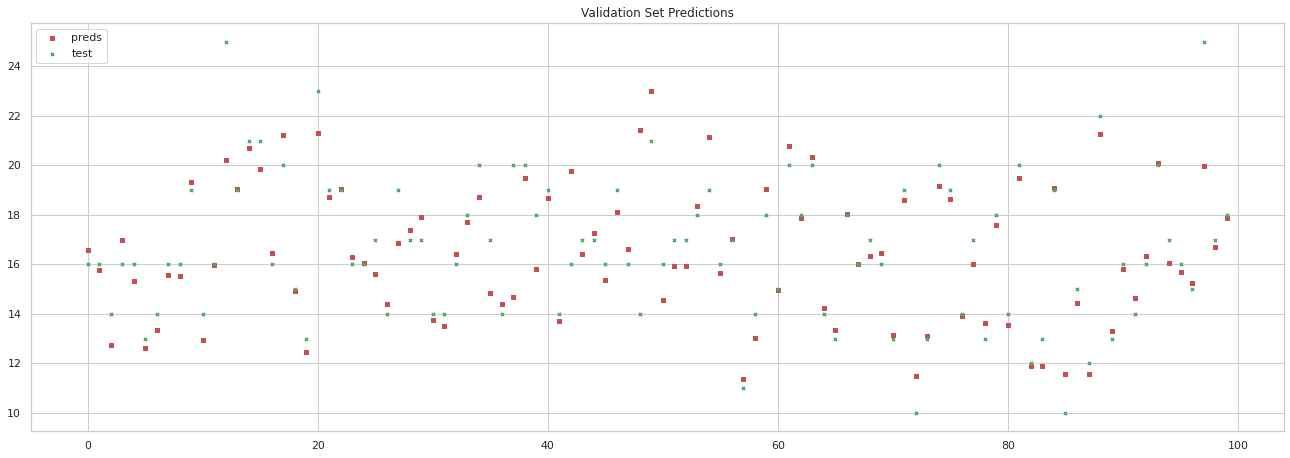

In [65]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(111)

ax1.scatter(a["index"][:100], a["preds"].values[:100], s=10, c='r', marker="s", label='preds') # we can define number of rows we want to see in the plot as we wish to see.
ax1.scatter(a["index"][:100], a["real"].values[:100], s=10, c='g', marker="x", label='test')
plt.legend(loc='upper left')
plt.title("Validation Set Predictions")
plt.show()

### Parameter Optimization

In [66]:
params = {
        'min_child_weight': [1, 5, 10,15],
        'colsample_bytree': [0.5, 0.7, 0.99],
        'num_leaves': [4,8,16,32,64,80],
        'num_iterations': [100,500,1000],
        'max_depth': [3, 4, 5,6,7, 10],
        "reg_lambda" : [0.2,0.5, 1, 1.5]
        }

In [67]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
param_comb = 6

kf = StratifiedKFold(n_splits = 5)

random_search = RandomizedSearchCV(model, param_distributions=params, n_iter=5, scoring='neg_mean_squared_error',  cv=kf.split(X,y), verbose=1, random_state=42 )

# Here we go
random_search.fit(X, y)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fc193281f90>,
                   estimator=LGBMRegressor(), n_iter=5,
                   param_distributions={'colsample_bytree': [0.5, 0.7, 0.99],
                                        'max_depth': [3, 4, 5, 6, 7, 10],
                                        'min_child_weight': [1, 5, 10, 15],
                                        'num_iterations': [100, 500, 1000],
                                        'num_leaves': [4, 8, 16, 32, 64, 80],
                                        'reg_lambda': [0.2, 0.5, 1, 1.5]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [68]:
print(random_search.best_params_)

{'reg_lambda': 0.2, 'num_leaves': 80, 'num_iterations': 1000, 'min_child_weight': 10, 'max_depth': 7, 'colsample_bytree': 0.7}


In [69]:
import lightgbm as lgb

model = lgb.LGBMRegressor(**random_search.best_params_)
model.fit(X_train, y_train, categorical_feature=CATEGORICAL_FEATURES)

preds = model.predict(X_val)
val_result2 = mean_squared_error(y_val, preds, squared= False)
val_result2

1.4178493234126934

##Test

In [70]:
model.fit(X, y)

real_preds = model.predict(test.drop(["duration",  "ENCOUNTER","dataset",  "patient", "icu_start", "icu_stop"],1))
lgb_tuned_rmse = mean_squared_error(test.duration, real_preds, squared= False)
lgb_tuned_mae = mae(test.duration, real_preds)
lgb_tuned_r2 = r2_score(test.duration, real_preds)



In [71]:
results = pd.DataFrame(test.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()

In [72]:
test.head()

,icu_start,icu_stop,patient,MARITAL,RACE,ETHNICITY,GENDER,CITY,COUNTY,healthcare_coverage_ratio,...,patient's_alergy_of_Allergy to tree pollen,patient's_alergy_of_House dust mite allergy,patient's_alergy_of_Shellfish allergy,patient's_alergy_of_Allergy to bee venom,patient's_alergy_of_Allergy to peanuts,patient's_alergy_of_Allergy to fish,patient's_alergy_of_Allergy to nut,patient's most seen allergy,doctor_count_per_city,dataset
662,2020-03-10,2020-03-27,9ec7d743-96e7-47c8-b2ee-6336633beb39,M,white,nonhispanic,M,Somerville,Middlesex County,0.004625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,test
663,2020-03-10,2020-03-24,46988a9c-9c86-429a-bc4a-b3d14ff321b0,S,asian,nonhispanic,M,Lunenburg,Worcester County,0.004374,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,test
664,2020-02-08,2020-02-20,33520eea-ab94-4024-aac8-fabd9e3361ea,M,white,nonhispanic,F,Winchester,Middlesex County,0.010435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,test
665,2020-03-02,2020-03-21,0b330870-5a8e-442c-b9c4-cb060a53ac82,M,white,nonhispanic,F,North Andover,Essex County,0.017057,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,test
666,2020-03-02,2020-03-20,56d6909b-e097-4ccb-919d-1000d199afd2,M,white,nonhispanic,F,Franklin,Norfolk County,0.005731,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,test


In [73]:
df["start_month"] = df.icu_start.dt.month
df["start_week"] = df.icu_start.dt.week
df["start_day"] = df.icu_start.dt.dayofyear

test["start_month"] = test.icu_start.dt.month
test["start_week"] = test.icu_start.dt.week
test["start_day"] = test.icu_start.dt.dayofyear

Text(0, 0.5, '% difference between real values and predictions')

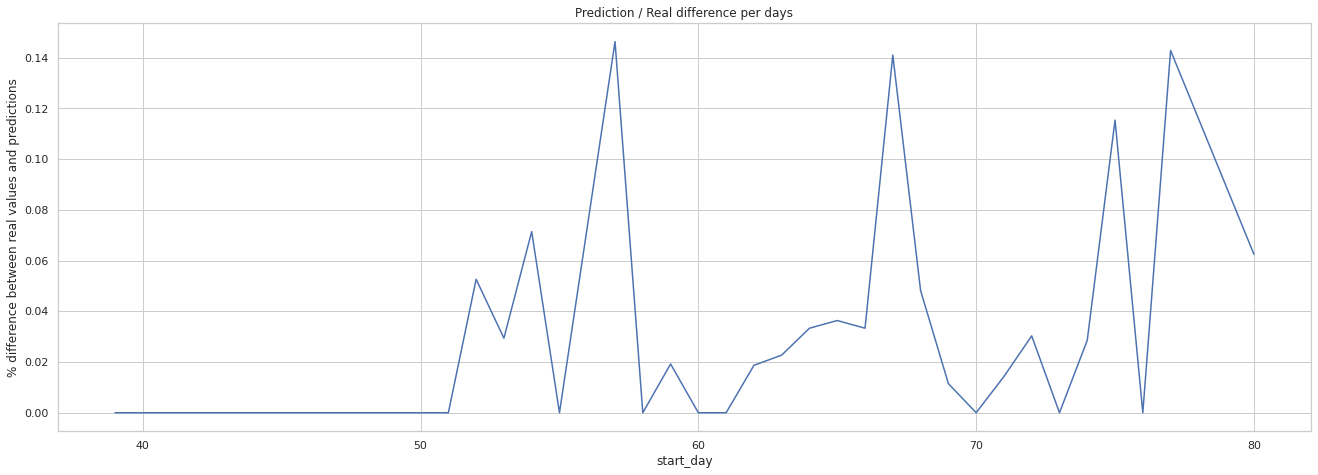

In [74]:
test["preds"] = a.preds.values
test["daily_preds_sum"] = test.groupby("start_day")["preds"].transform("sum").astype(int)
test["daily_real_sum"] = test.groupby("start_day")["duration"].transform("sum")
temp = test.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions")

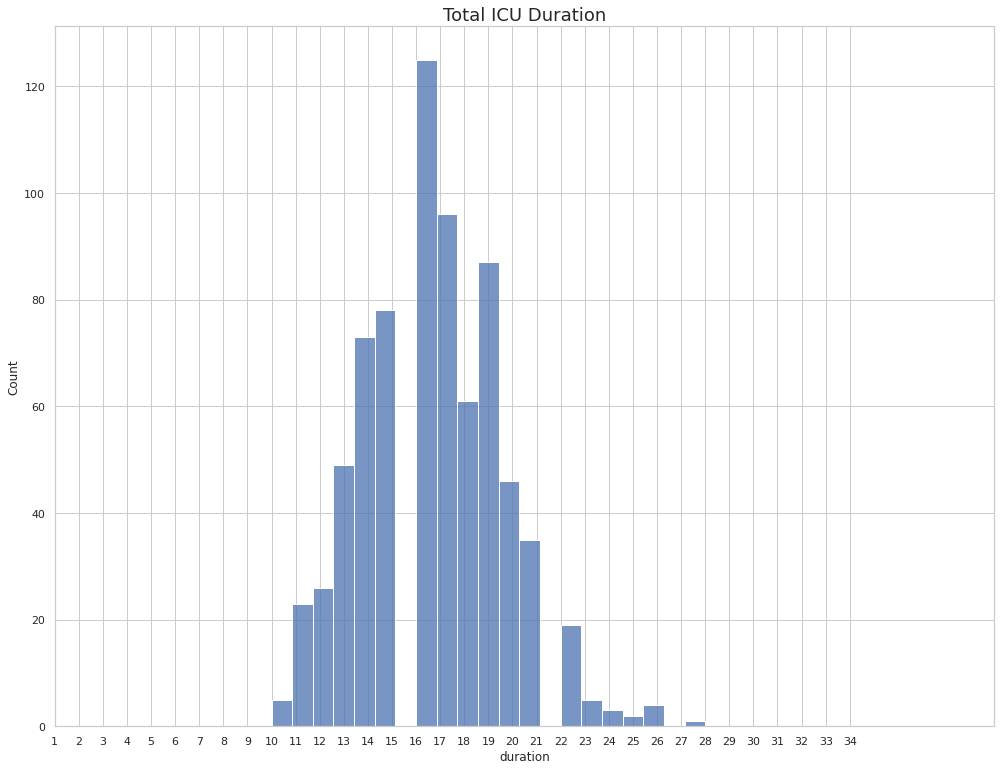

In [75]:
plt.figure(figsize = (15,12))
sns.histplot(data = df, x = "duration")
plt.xticks(np.arange(1,35,1))
plt.xlim(1,40)
plt.title('Total ICU Duration', fontsize = 18)
plt.show()

Text(0, 0.5, 'frequency')

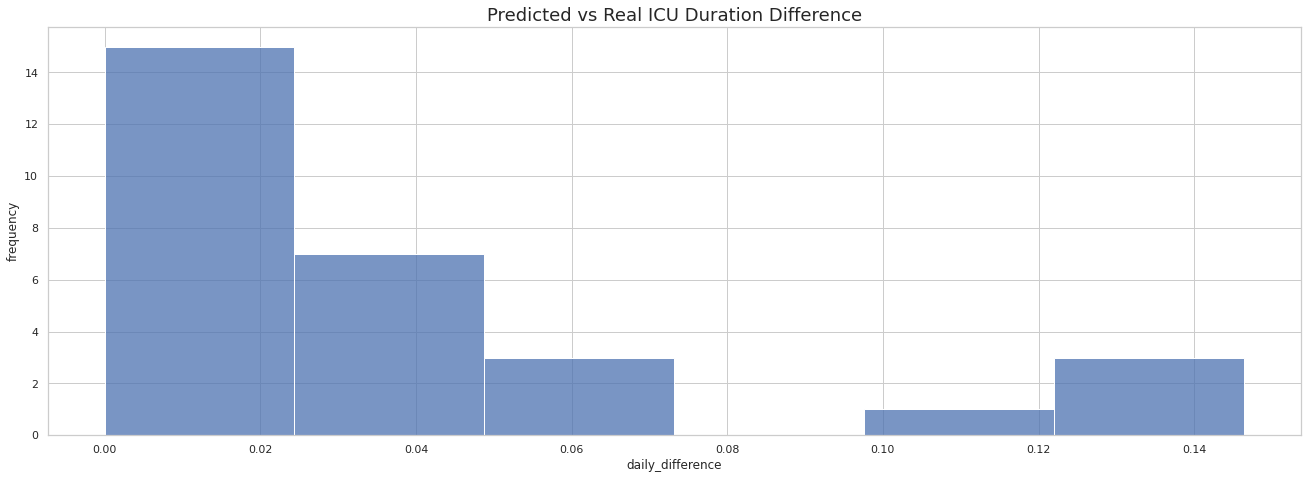

In [76]:
plt.figure(figsize = (20,7))
sns.histplot(data = temp, x = "daily_difference")
plt.title("Predicted vs Real ICU Duration Difference", fontsize = 18)
plt.ylabel("frequency")

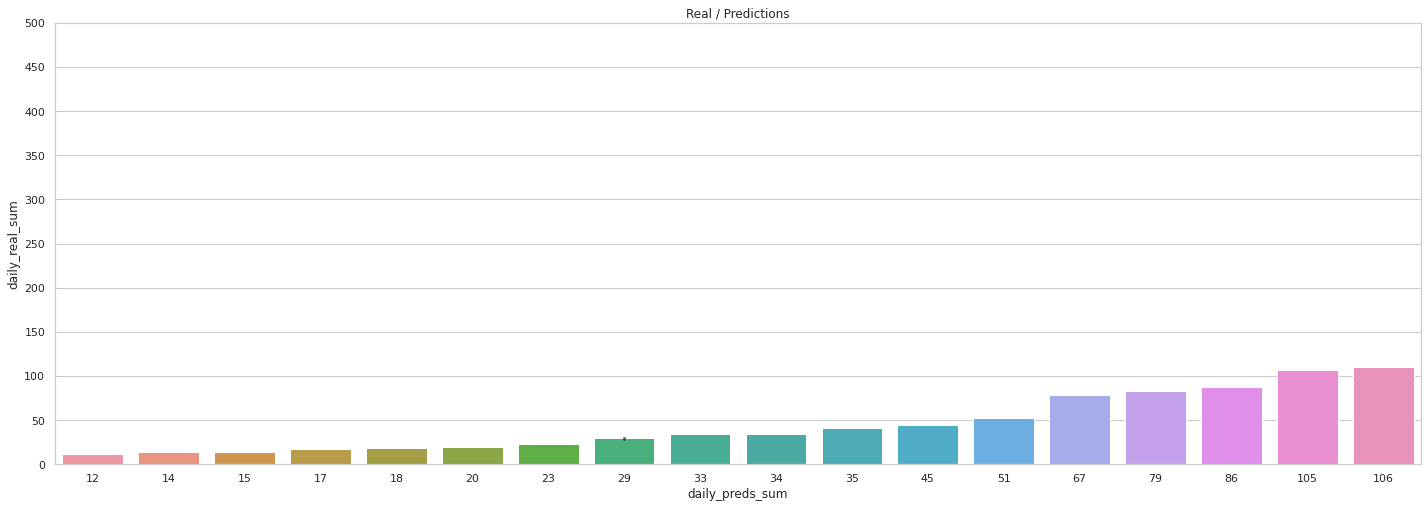

In [77]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20])
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions")
plt.show()

In [78]:
np.std([test.preds, test.duration])

3.0713493054005627

Text(0.5, 1.0, 'Daily differences between real values and predictions')

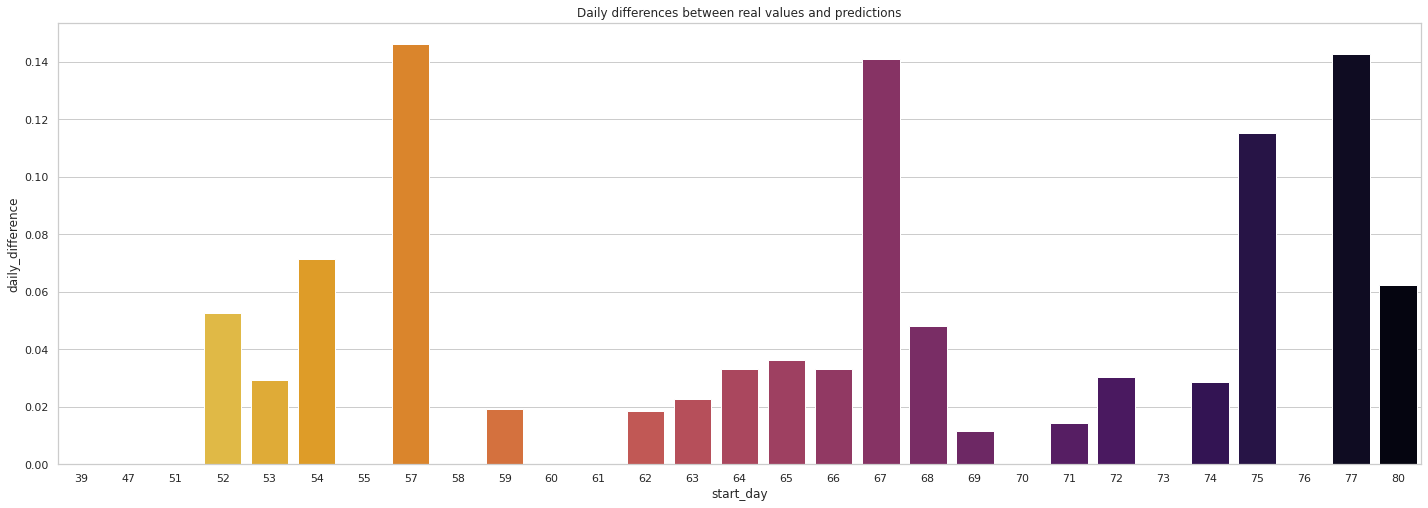

In [79]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions")

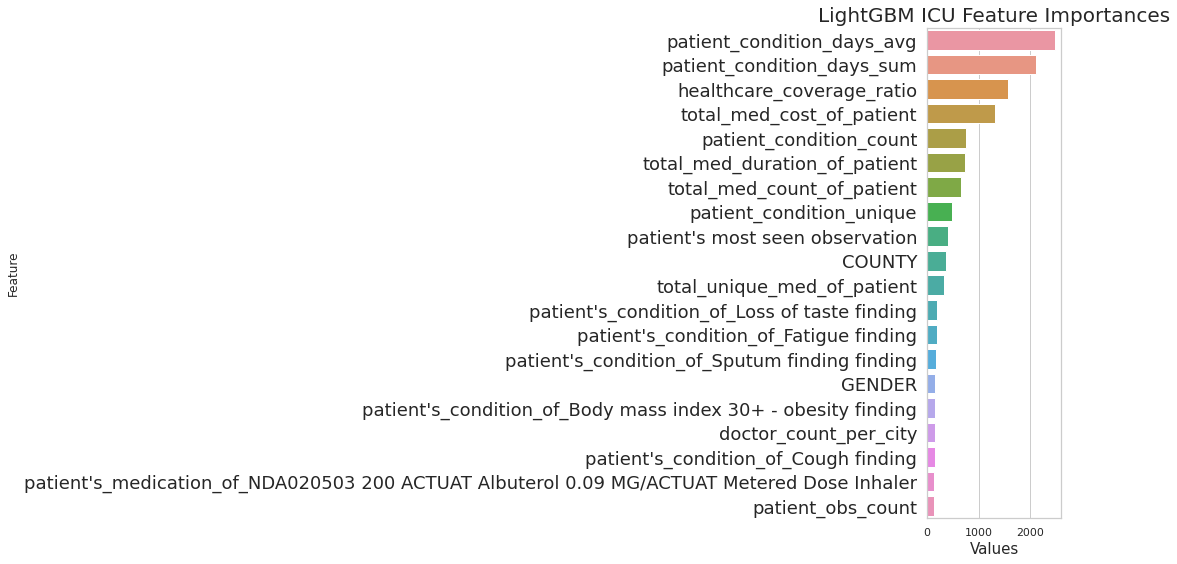

<Figure size 432x288 with 0 Axes>

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(15, 8))
p = sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[:20])
_, ylabels = plt.yticks()
p.set_yticklabels(ylabels, size=18)
p.set_xlabel("Values", size = 15)

plt.title('LightGBM ICU Feature Importances', fontsize = 20)
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importance-hospital.png')

### FT - Transformer Models

In [2]:
#!pip install tensorflow_addons

In [3]:
#!pip install tabtransformertf


In [83]:
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
import tensorflow_addons as tfa
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')


from tensorflow.keras.callbacks import EarlyStopping

from tabtransformertf.models.fttransformer import FTTransformerEncoder, FTTransformer
from tabtransformertf.utils.preprocessing import df_to_dataset

#import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns

def cat_analyser(data, col, freq_limit = None):
    if freq_limit == None:
        freq_limit = data[col].nunique()
        if freq_limit >= 12:
            freq_limit = 12
    df_ = data.copy()
    sns.set(rc = {'axes.facecolor': 'gainsboro',
                  'figure.facecolor': 'gainsboro'})
    if freq_limit < 6 or col == "Year":
        if df_[col].nunique() > freq_limit:
            df_ = df_.loc[df_[col].isin(df_[col].value_counts(). \
                                        keys()[:freq_limit].tolist())]
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
        plt.tight_layout()
        #fig.suptitle(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    x = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts().index)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
    
        plt.show()
        sns.reset_orig()
    else:
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, freq_limit*1.5))
        #ax.set_title(col, fontsize = 16)
        a = sns.countplot(data = df_,
                    y = col,
                    ax = ax[0],
                    palette= "viridis",
                    order =  df_[col].value_counts()[:freq_limit].index)
        a.tick_params(axis = "x", rotation = 90)
        a.set_title(col, fontsize = 15)
        ax[0].set_xlabel('')
        pie_cmap = plt.get_cmap("Set3")
        normalize = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)) 
        data[col].value_counts()[:freq_limit].plot.pie(autopct = '%1.1f%%',
                                        textprops = {'fontsize': 12},
                                        ax = ax[1],
                                        colors = pie_cmap(normalize(df_[col].value_counts())))
        ax[1].set_ylabel('')
        plt.show()
        plt.tight_layout()
        sns.reset_orig()

In [84]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
import warnings
warnings.filterwarnings('ignore')



In [85]:
data = df.copy()
data = data.loc[data.duration > 0].reset_index(drop = True)

In [86]:
y = data['duration']
LABEL = "duration"

In [87]:
test_data = data.loc[data.dataset == "test"].drop(["dataset"],1).reset_index(drop = True)
train_data = data.loc[data.dataset == "train"].drop(["dataset"],1).reset_index(drop = True)

In [88]:
FEATURES = list(NUMERIC_FEATURES) + list(CATEGORICAL_FEATURES)

In [89]:
CATEGORICAL_FEATURES

['MARITAL',
 'RACE',
 'ETHNICITY',
 'GENDER',
 'CITY',
 'COUNTY',
 "patient's most seen condition",
 "patient's_observation_of_Systolic_Blood_Pressure",
 "patient's_observation_of_Respiratory_rate",
 "patient's_observation_of_Diastolic_Blood_Pressure",
 "patient's_observation_of_Heart_rate",
 "patient's_observation_of_Body_Weight",
 "patient's_observation_of_Oxygen_saturation_in_Arterial_blood",
 "patient's_observation_of_Body_temperature",
 "patient's_observation_of_Alanine_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Protein_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Albumin_Massvolume_in_Serum_or_Plasma",
 "patient's_observation_of_Platelets_volume_in_Blood_by_Automated_count",
 "patient's_observation_of_MCH_Entitic_mass_by_Automated_count",
 "patient's_observation_of_Aspartate_aminotransferase_Enzymatic_activityvolume_in_Serum_or_Plasma",
 "patient's_observation_of_MCV_Entitic_volume_by_Automated_count",
 "patient's_obser

In [90]:
NUMERIC_FEATURES

['healthcare_coverage_ratio',
 "patient's_condition_of_Suspected COVID-19",
 "patient's_condition_of_COVID-19",
 "patient's_condition_of_Fever finding",
 "patient's_condition_of_Cough finding",
 "patient's_condition_of_Body mass index 30+ - obesity finding",
 "patient's_condition_of_Loss of taste finding",
 "patient's_condition_of_Prediabetes",
 "patient's_condition_of_Anemia disorder",
 "patient's_condition_of_Fatigue finding",
 "patient's_condition_of_Hypertension",
 "patient's_condition_of_Sputum finding finding",
 "patient's_condition_of_Chronic sinusitis disorder",
 "patient's_condition_of_Miscarriage in first trimester",
 "patient's_condition_of_Pneumonia disorder",
 "patient's_condition_of_Hypoxemia disorder",
 "patient's_condition_of_Respiratory distress finding",
 "patient's_condition_of_Dyspnea finding",
 "patient's_condition_of_Wheezing finding",
 "patient's_condition_of_Viral sinusitis disorder",
 "patient's_condition_of_Hyperlipidemia",
 "patient's_condition_of_Joint pain 

In [91]:
# Set data types
train_data[CATEGORICAL_FEATURES] = train_data[CATEGORICAL_FEATURES].astype(str)
test_data[CATEGORICAL_FEATURES] = test_data[CATEGORICAL_FEATURES].astype(str)

train_data[NUMERIC_FEATURES] = train_data[NUMERIC_FEATURES].astype(float)
test_data[NUMERIC_FEATURES] = test_data[NUMERIC_FEATURES].astype(float)

In [92]:
# Train/test split
X_train, X_val = train_test_split(train_data, test_size=0.2)

In [93]:
sc = StandardScaler()
X_train.loc[:, NUMERIC_FEATURES] = sc.fit_transform(X_train[NUMERIC_FEATURES])
X_val.loc[:, NUMERIC_FEATURES] = sc.transform(X_val[NUMERIC_FEATURES])
test_data.loc[:, NUMERIC_FEATURES] = sc.transform(test_data[NUMERIC_FEATURES])

In [94]:
train_dataset = df_to_dataset(X_train[FEATURES + [LABEL]], LABEL)
val_dataset = df_to_dataset(X_val[FEATURES + [LABEL]], LABEL, shuffle=False)  # No shuffle
test_dataset = df_to_dataset(test_data[FEATURES + [LABEL]], shuffle=False) # No target, no shuffle

In [95]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    embedding_dim=32,
    depth=4,
    heads=8,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_linear_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 20s 2s/step - loss: 276.4333 - output_loss: 276.4333 - output_rmse: 16.6263 - val_loss: 209.4738 - val_output_loss: 209.4738 - val_output_rmse: 14.4732
Epoch 2/250
2/2 [==============================] - 0s 120ms/step - loss: 214.6638 - output_loss: 214.6638 - output_rmse: 14.6514 - val_loss: 162.6323 - val_output_loss: 162.6323 - val_output_rmse: 12.7527
Epoch 3/250
2/2 [==============================] - 0s 117ms/step - loss: 164.9047 - output_loss: 164.9047 - output_rmse: 12.8415 - val_loss: 133.5379 - val_output_loss: 133.5379 - val_output_rmse: 11.5559
Epoch 4/250
2/2 [==============================] - 0s 116ms/step - loss: 133.5637 - output_loss: 133.5637 - output_rmse: 11.5570 - val_loss: 115.4848 - val_output_loss: 115.4848 - val_output_rmse: 10.7464
Epoch 5/250
2/2 [==============================] - 0s 113ms/step - loss: 112.4952 - output_loss: 112.4952 - output_rmse: 10.6064 - val_loss: 100.9709 - val_output_loss: 100.9709 - va

In [96]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=32,
    embedding_dim=16,
    depth=3,
    heads=6,
    attn_dropout=0.3,
    ff_dropout=0.3,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 12s 1s/step - loss: 269.7681 - output_loss: 269.7681 - output_rmse: 16.4246 - val_loss: 262.6116 - val_output_loss: 262.6116 - val_output_rmse: 16.2053
Epoch 2/250
2/2 [==============================] - 0s 105ms/step - loss: 256.4437 - output_loss: 256.4437 - output_rmse: 16.0139 - val_loss: 245.2200 - val_output_loss: 245.2200 - val_output_rmse: 15.6595
Epoch 3/250
2/2 [==============================] - 0s 105ms/step - loss: 246.5188 - output_loss: 246.5188 - output_rmse: 15.7009 - val_loss: 231.0650 - val_output_loss: 231.0650 - val_output_rmse: 15.2008
Epoch 4/250
2/2 [==============================] - 0s 104ms/step - loss: 234.3383 - output_loss: 234.3383 - output_rmse: 15.3081 - val_loss: 219.6287 - val_output_loss: 219.6287 - val_output_rmse: 14.8199
Epoch 5/250
2/2 [==============================] - 0s 111ms/step - loss: 225.6670 - output_loss: 225.6670 - output_rmse: 15.0222 - val_loss: 211.6915 - val_output_loss: 211.6915 - va

In [97]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score
linear_test_preds = ft_linear_transformer.predict(test_dataset)
linear_rms = mean_squared_error(test_data[LABEL], linear_test_preds['output'].ravel(), squared=False)
linear_mae = mae(test_data[LABEL], linear_test_preds['output'].ravel())
linear_mape = mape(test_data[LABEL], linear_test_preds['output'].ravel())
linear_r2 = r2_score(test_data[LABEL], linear_test_preds['output'])

periodic_test_preds = ft_periodic_transformer.predict(test_dataset)
periodic_rms = mean_squared_error(test_data[LABEL], periodic_test_preds['output'].ravel(), squared=False)
period_mae = mae(test_data[LABEL], periodic_test_preds['output'].ravel())
periodic_r2 = r2_score(test_data[LABEL], linear_test_preds['output'].ravel())


1/1 [==============================] - 1s 1s/step


In [4]:
#pip install optuna

### Parameter Optimization for Transformer Models

In [99]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='periodic',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-16 01:42:39,767] A new study created in memory with name: no-name-d8908da9-4978-4883-97b4-a5802178f902


Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 274.2008 - output_loss: 274.2008 - output_rmse: 16.5590 - val_loss: 135.3443 - val_output_loss: 135.3443 - val_output_rmse: 11.6338
Epoch 2/150
2/2 [==============================] - 0s 121ms/step - loss: 142.2912 - output_loss: 142.2912 - output_rmse: 11.9286 - val_loss: 51.0954 - val_output_loss: 51.0954 - val_output_rmse: 7.1481
Epoch 3/150
2/2 [==============================] - 0s 116ms/step - loss: 69.0447 - output_loss: 69.0447 - output_rmse: 8.3093 - val_loss: 27.6385 - val_output_loss: 27.6385 - val_output_rmse: 5.2572
Epoch 4/150
2/2 [==============================] - 0s 123ms/step - loss: 33.7786 - output_loss: 33.7786 - output_rmse: 5.8119 - val_loss: 18.0707 - val_output_loss: 18.0707 - val_output_rmse: 4.2510
Epoch 5/150
2/2 [==============================] - 0s 121ms/step - loss: 17.6575 - output_loss: 17.6575 - output_rmse: 4.2021 - val_loss: 14.5508 - val_output_loss: 14.5508 - val_output_rmse: 3.814

[I 2023-01-16 01:43:01,754] Trial 0 finished with value: 3.322677513694734 and parameters: {'numerical_bins': 21, 'embedding_dim': 81, 'depth': 3, 'heads': 7, 'attn_dropout': 0.3871363096230404, 'ff_dropout': 0.26443556995675677}. Best is trial 0 with value: 3.322677513694734.


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 253.3290 - output_loss: 253.3290 - output_rmse: 15.9163 - val_loss: 120.8304 - val_output_loss: 120.8304 - val_output_rmse: 10.9923
Epoch 2/150
2/2 [==============================] - 0s 119ms/step - loss: 137.6667 - output_loss: 137.6667 - output_rmse: 11.7331 - val_loss: 63.3199 - val_output_loss: 63.3199 - val_output_rmse: 7.9574
Epoch 3/150
2/2 [==============================] - 0s 123ms/step - loss: 77.3108 - output_loss: 77.3108 - output_rmse: 8.7927 - val_loss: 40.7303 - val_output_loss: 40.7303 - val_output_rmse: 6.3820
Epoch 4/150
2/2 [==============================] - 0s 119ms/step - loss: 46.3704 - output_loss: 46.3704 - output_rmse: 6.8096 - val_loss: 31.0044 - val_output_loss: 31.0044 - val_output_rmse: 5.5682
Epoch 5/150
2/2 [==============================] - 0s 120ms/step - loss: 30.3763 - output_loss: 30.3763 - output_rmse: 5.5115 - val_loss: 25.3017 - val_output_loss: 25.3017 - val_output_rmse: 5.030

[I 2023-01-16 01:43:24,991] Trial 1 finished with value: 3.322094162100899 and parameters: {'numerical_bins': 197, 'embedding_dim': 86, 'depth': 3, 'heads': 7, 'attn_dropout': 0.10170668988194642, 'ff_dropout': 0.34060906626296583}. Best is trial 1 with value: 3.322094162100899.


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 240.3939 - output_loss: 240.3939 - output_rmse: 15.5046 - val_loss: 111.3884 - val_output_loss: 111.3884 - val_output_rmse: 10.5541
Epoch 2/150
2/2 [==============================] - 0s 113ms/step - loss: 102.2266 - output_loss: 102.2266 - output_rmse: 10.1107 - val_loss: 66.2042 - val_output_loss: 66.2042 - val_output_rmse: 8.1366
Epoch 3/150
2/2 [==============================] - 0s 110ms/step - loss: 60.3579 - output_loss: 60.3579 - output_rmse: 7.7690 - val_loss: 47.5216 - val_output_loss: 47.5216 - val_output_rmse: 6.8936
Epoch 4/150
2/2 [==============================] - 0s 114ms/step - loss: 42.3518 - output_loss: 42.3518 - output_rmse: 6.5078 - val_loss: 35.2290 - val_output_loss: 35.2290 - val_output_rmse: 5.9354
Epoch 5/150
2/2 [==============================] - 0s 111ms/step - loss: 30.2768 - output_loss: 30.2768 - output_rmse: 5.5024 - val_loss: 29.5591 - val_output_loss: 29.5591 - val_output_rmse: 5.436

1/1 [==============================] - 1s 1s/step


[I 2023-01-16 01:43:47,212] Trial 2 finished with value: 3.321874733675684 and parameters: {'numerical_bins': 150, 'embedding_dim': 86, 'depth': 3, 'heads': 2, 'attn_dropout': 0.3134832038399728, 'ff_dropout': 0.03714659578072671}. Best is trial 2 with value: 3.321874733675684.


Epoch 1/150
2/2 [==============================] - 15s 2s/step - loss: 275.7756 - output_loss: 275.7756 - output_rmse: 16.6065 - val_loss: 177.9868 - val_output_loss: 177.9868 - val_output_rmse: 13.3412
Epoch 2/150
2/2 [==============================] - 0s 159ms/step - loss: 179.9343 - output_loss: 179.9343 - output_rmse: 13.4140 - val_loss: 113.8473 - val_output_loss: 113.8473 - val_output_rmse: 10.6699
Epoch 3/150
2/2 [==============================] - 0s 157ms/step - loss: 117.1256 - output_loss: 117.1256 - output_rmse: 10.8225 - val_loss: 84.5441 - val_output_loss: 84.5441 - val_output_rmse: 9.1948
Epoch 4/150
2/2 [==============================] - 0s 152ms/step - loss: 82.4963 - output_loss: 82.4963 - output_rmse: 9.0827 - val_loss: 72.4975 - val_output_loss: 72.4975 - val_output_rmse: 8.5145
Epoch 5/150
2/2 [==============================] - 0s 160ms/step - loss: 66.8645 - output_loss: 66.8645 - output_rmse: 8.1771 - val_loss: 65.3686 - val_output_loss: 65.3686 - val_output_rmse:

1/1 [==============================] - 2s 2s/step


[I 2023-01-16 01:44:29,133] Trial 3 finished with value: 3.314317503963635 and parameters: {'numerical_bins': 172, 'embedding_dim': 78, 'depth': 6, 'heads': 7, 'attn_dropout': 0.47950174036867715, 'ff_dropout': 0.2850638887496107}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 11s 1s/step - loss: 278.3740 - output_loss: 278.3740 - output_rmse: 16.6845 - val_loss: 221.4556 - val_output_loss: 221.4556 - val_output_rmse: 14.8814
Epoch 2/150
2/2 [==============================] - 0s 106ms/step - loss: 211.6884 - output_loss: 211.6884 - output_rmse: 14.5495 - val_loss: 201.9056 - val_output_loss: 201.9056 - val_output_rmse: 14.2094
Epoch 3/150
2/2 [==============================] - 0s 110ms/step - loss: 191.9382 - output_loss: 191.9382 - output_rmse: 13.8542 - val_loss: 178.3553 - val_output_loss: 178.3553 - val_output_rmse: 13.3550
Epoch 4/150
2/2 [==============================] - 0s 112ms/step - loss: 170.8707 - output_loss: 170.8707 - output_rmse: 13.0718 - val_loss: 164.6334 - val_output_loss: 164.6334 - val_output_rmse: 12.8310
Epoch 5/150
2/2 [==============================] - 0s 108ms/step - loss: 156.7563 - output_loss: 156.7563 - output_rmse: 12.5202 - val_loss: 147.5007 - val_output_loss: 147.5007 - va

[I 2023-01-16 01:44:59,077] Trial 4 finished with value: 3.3151576284458253 and parameters: {'numerical_bins': 119, 'embedding_dim': 41, 'depth': 3, 'heads': 4, 'attn_dropout': 0.03571187060870845, 'ff_dropout': 0.09220080388278973}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 14s 2s/step - loss: 275.6153 - output_loss: 275.6153 - output_rmse: 16.6017 - val_loss: 157.2805 - val_output_loss: 157.2805 - val_output_rmse: 12.5412
Epoch 2/150
2/2 [==============================] - 0s 145ms/step - loss: 145.3237 - output_loss: 145.3237 - output_rmse: 12.0550 - val_loss: 78.8831 - val_output_loss: 78.8831 - val_output_rmse: 8.8816
Epoch 3/150
2/2 [==============================] - 0s 141ms/step - loss: 70.4555 - output_loss: 70.4555 - output_rmse: 8.3938 - val_loss: 48.2786 - val_output_loss: 48.2786 - val_output_rmse: 6.9483
Epoch 4/150
2/2 [==============================] - 0s 139ms/step - loss: 42.0016 - output_loss: 42.0016 - output_rmse: 6.4809 - val_loss: 36.6278 - val_output_loss: 36.6278 - val_output_rmse: 6.0521
Epoch 5/150
2/2 [==============================] - 0s 147ms/step - loss: 30.4367 - output_loss: 30.4367 - output_rmse: 5.5169 - val_loss: 30.7832 - val_output_loss: 30.7832 - val_output_rmse: 5.548

[I 2023-01-16 01:45:28,505] Trial 5 finished with value: 3.3218861141368525 and parameters: {'numerical_bins': 200, 'embedding_dim': 97, 'depth': 5, 'heads': 4, 'attn_dropout': 0.3809848346926692, 'ff_dropout': 0.03631349845425402}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 13s 2s/step - loss: 243.4942 - output_loss: 243.4942 - output_rmse: 15.6043 - val_loss: 169.7993 - val_output_loss: 169.7993 - val_output_rmse: 13.0307
Epoch 2/150
2/2 [==============================] - 0s 117ms/step - loss: 163.9518 - output_loss: 163.9518 - output_rmse: 12.8044 - val_loss: 140.2018 - val_output_loss: 140.2018 - val_output_rmse: 11.8407
Epoch 3/150
2/2 [==============================] - 0s 118ms/step - loss: 135.0232 - output_loss: 135.0232 - output_rmse: 11.6200 - val_loss: 121.7825 - val_output_loss: 121.7825 - val_output_rmse: 11.0355
Epoch 4/150
2/2 [==============================] - 0s 151ms/step - loss: 117.5321 - output_loss: 117.5321 - output_rmse: 10.8412 - val_loss: 109.2675 - val_output_loss: 109.2675 - val_output_rmse: 10.4531
Epoch 5/150
2/2 [==============================] - 0s 119ms/step - loss: 104.6874 - output_loss: 104.6874 - output_rmse: 10.2317 - val_loss: 100.9910 - val_output_loss: 100.9910 - va

[I 2023-01-16 01:46:11,773] Trial 6 finished with value: 3.3187018479423247 and parameters: {'numerical_bins': 86, 'embedding_dim': 40, 'depth': 4, 'heads': 7, 'attn_dropout': 0.20628353572425384, 'ff_dropout': 0.11682071098147473}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 275.0134 - output_loss: 275.0134 - output_rmse: 16.5835 - val_loss: 269.2574 - val_output_loss: 269.2574 - val_output_rmse: 16.4091
Epoch 2/150
2/2 [==============================] - 0s 106ms/step - loss: 256.0142 - output_loss: 256.0142 - output_rmse: 16.0004 - val_loss: 259.8612 - val_output_loss: 259.8612 - val_output_rmse: 16.1202
Epoch 3/150
2/2 [==============================] - 0s 107ms/step - loss: 246.7909 - output_loss: 246.7909 - output_rmse: 15.7096 - val_loss: 250.0793 - val_output_loss: 250.0793 - val_output_rmse: 15.8139
Epoch 4/150
2/2 [==============================] - 0s 108ms/step - loss: 239.0658 - output_loss: 239.0658 - output_rmse: 15.4618 - val_loss: 244.1643 - val_output_loss: 244.1643 - val_output_rmse: 15.6258
Epoch 5/150
2/2 [==============================] - 0s 108ms/step - loss: 232.9149 - output_loss: 232.9149 - output_rmse: 15.2615 - val_loss: 239.1418 - val_output_loss: 239.1418 - va

[I 2023-01-16 01:46:57,059] Trial 7 finished with value: 3.320176772527815 and parameters: {'numerical_bins': 118, 'embedding_dim': 17, 'depth': 3, 'heads': 4, 'attn_dropout': 0.24716121913190697, 'ff_dropout': 0.2553260890920516}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 13s 2s/step - loss: 270.2350 - output_loss: 270.2350 - output_rmse: 16.4388 - val_loss: 102.2832 - val_output_loss: 102.2832 - val_output_rmse: 10.1135
Epoch 2/150
2/2 [==============================] - 0s 130ms/step - loss: 115.8754 - output_loss: 115.8754 - output_rmse: 10.7645 - val_loss: 64.3170 - val_output_loss: 64.3170 - val_output_rmse: 8.0198
Epoch 3/150
2/2 [==============================] - 0s 124ms/step - loss: 67.9723 - output_loss: 67.9723 - output_rmse: 8.2445 - val_loss: 45.9131 - val_output_loss: 45.9131 - val_output_rmse: 6.7759
Epoch 4/150
2/2 [==============================] - 0s 128ms/step - loss: 45.7873 - output_loss: 45.7873 - output_rmse: 6.7666 - val_loss: 36.7512 - val_output_loss: 36.7512 - val_output_rmse: 6.0623
Epoch 5/150
2/2 [==============================] - 0s 132ms/step - loss: 33.9988 - output_loss: 33.9988 - output_rmse: 5.8309 - val_loss: 30.6490 - val_output_loss: 30.6490 - val_output_rmse: 5.536

[I 2023-01-16 01:47:24,073] Trial 8 finished with value: 3.3220745840917276 and parameters: {'numerical_bins': 132, 'embedding_dim': 75, 'depth': 4, 'heads': 6, 'attn_dropout': 0.3744594753512053, 'ff_dropout': 0.24047914010950472}. Best is trial 3 with value: 3.314317503963635.


Epoch 1/150
2/2 [==============================] - 16s 2s/step - loss: 273.3065 - output_loss: 273.3065 - output_rmse: 16.5320 - val_loss: 111.3138 - val_output_loss: 111.3138 - val_output_rmse: 10.5505
Epoch 2/150
2/2 [==============================] - 0s 153ms/step - loss: 127.1559 - output_loss: 127.1559 - output_rmse: 11.2763 - val_loss: 53.5891 - val_output_loss: 53.5891 - val_output_rmse: 7.3205
Epoch 3/150
2/2 [==============================] - 0s 150ms/step - loss: 59.2537 - output_loss: 59.2537 - output_rmse: 7.6976 - val_loss: 32.0079 - val_output_loss: 32.0079 - val_output_rmse: 5.6576
Epoch 4/150
2/2 [==============================] - 0s 153ms/step - loss: 31.5059 - output_loss: 31.5059 - output_rmse: 5.6130 - val_loss: 23.4064 - val_output_loss: 23.4064 - val_output_rmse: 4.8380
Epoch 5/150
2/2 [==============================] - 0s 151ms/step - loss: 20.5129 - output_loss: 20.5129 - output_rmse: 4.5291 - val_loss: 19.4185 - val_output_loss: 19.4185 - val_output_rmse: 4.406

[I 2023-01-16 01:47:57,774] Trial 9 finished with value: 3.325337026605324 and parameters: {'numerical_bins': 105, 'embedding_dim': 99, 'depth': 6, 'heads': 5, 'attn_dropout': 0.38355032948085627, 'ff_dropout': 0.32495385286169026}. Best is trial 3 with value: 3.314317503963635.


Number of finished trials: 10
Best trial: {'numerical_bins': 172, 'embedding_dim': 78, 'depth': 6, 'heads': 7, 'attn_dropout': 0.47950174036867715, 'ff_dropout': 0.2850638887496107}


In [100]:
ft_periodic_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='periodic',
    numerical_bins=109,
    embedding_dim=90,
    depth=2,
    heads=8,
    attn_dropout= 0.43651857547406014,
    ff_dropout= 0.04959838229272473,
    explainable=True
)

# Pass th encoder to the model
ft_periodic_encoder_transformer = FTTransformer(
    encoder=ft_periodic_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_periodic_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_periodic_history = ft_periodic_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 11s 1s/step - loss: 276.6450 - output_loss: 276.6450 - output_rmse: 16.6326 - val_loss: 188.8936 - val_output_loss: 188.8936 - val_output_rmse: 13.7439
Epoch 2/250
2/2 [==============================] - 0s 112ms/step - loss: 176.1815 - output_loss: 176.1815 - output_rmse: 13.2733 - val_loss: 145.4502 - val_output_loss: 145.4502 - val_output_rmse: 12.0603
Epoch 3/250
2/2 [==============================] - 0s 119ms/step - loss: 133.9597 - output_loss: 133.9597 - output_rmse: 11.5741 - val_loss: 112.1768 - val_output_loss: 112.1768 - val_output_rmse: 10.5914
Epoch 4/250
2/2 [==============================] - 0s 125ms/step - loss: 103.1450 - output_loss: 103.1450 - output_rmse: 10.1560 - val_loss: 95.1371 - val_output_loss: 95.1371 - val_output_rmse: 9.7538
Epoch 5/250
2/2 [==============================] - 0s 113ms/step - loss: 85.5785 - output_loss: 85.5785 - output_rmse: 9.2509 - val_loss: 86.4965 - val_output_loss: 86.4965 - val_output

In [101]:
periodic_tuned_test_preds = ft_periodic_encoder_transformer.predict(test_dataset)
periodic_tuned_rms = mean_squared_error(test_data[LABEL], periodic_tuned_test_preds['output'].ravel(), squared=False)
periodic_tuned_mae = mae(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())
periodic_tuned_r2 = r2_score(test_data[LABEL], periodic_tuned_test_preds['output'].ravel())


1/1 [==============================] - 1s 1s/step


### Periodic Encoding FT Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Periodic Encoding FT )')

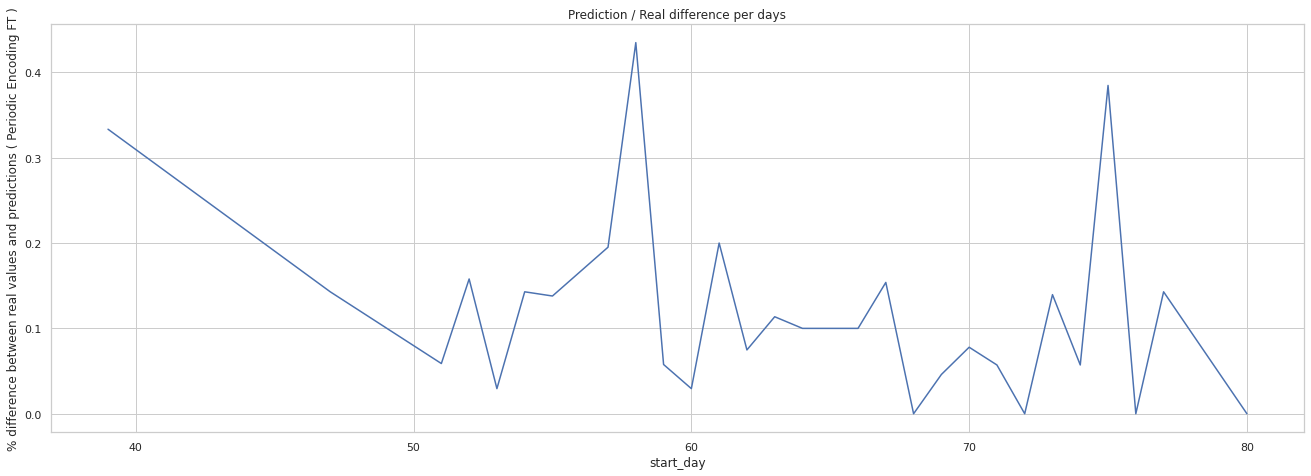

In [102]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = periodic_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Periodic Encoding FT )")

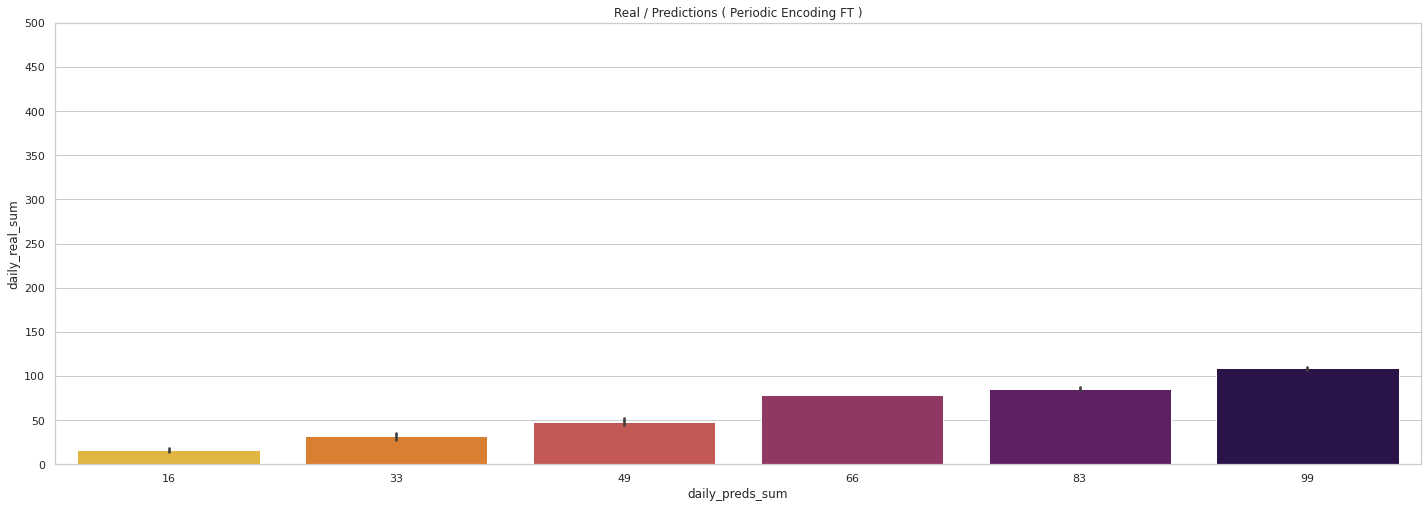

In [103]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Periodic Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Periodic Encoding FT )')

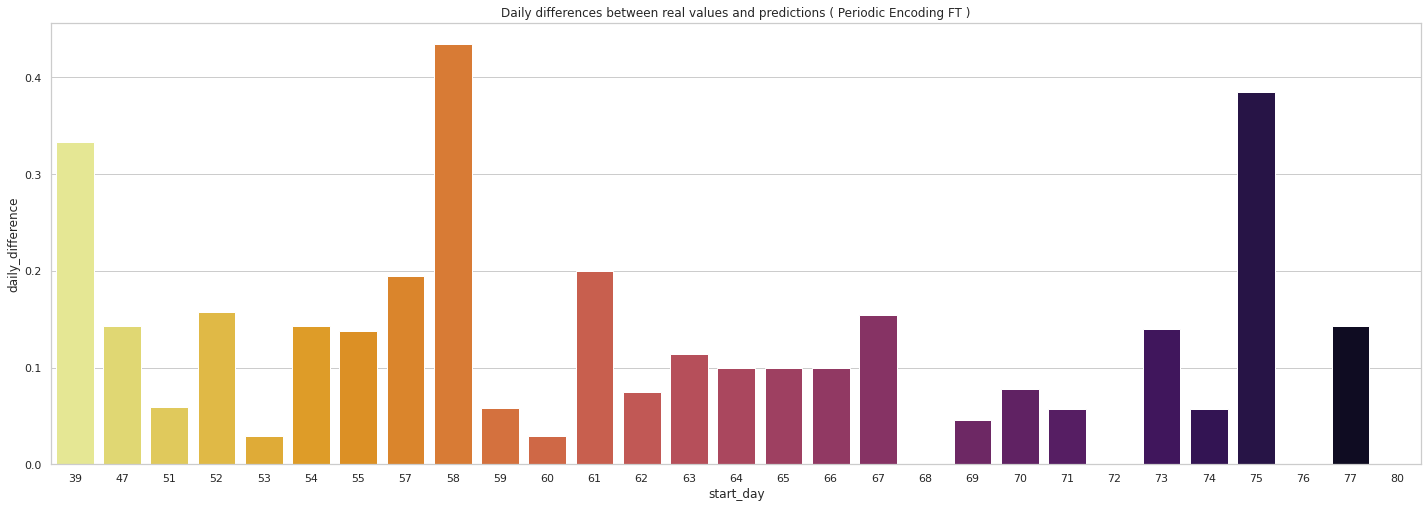

In [104]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Periodic Encoding FT )")

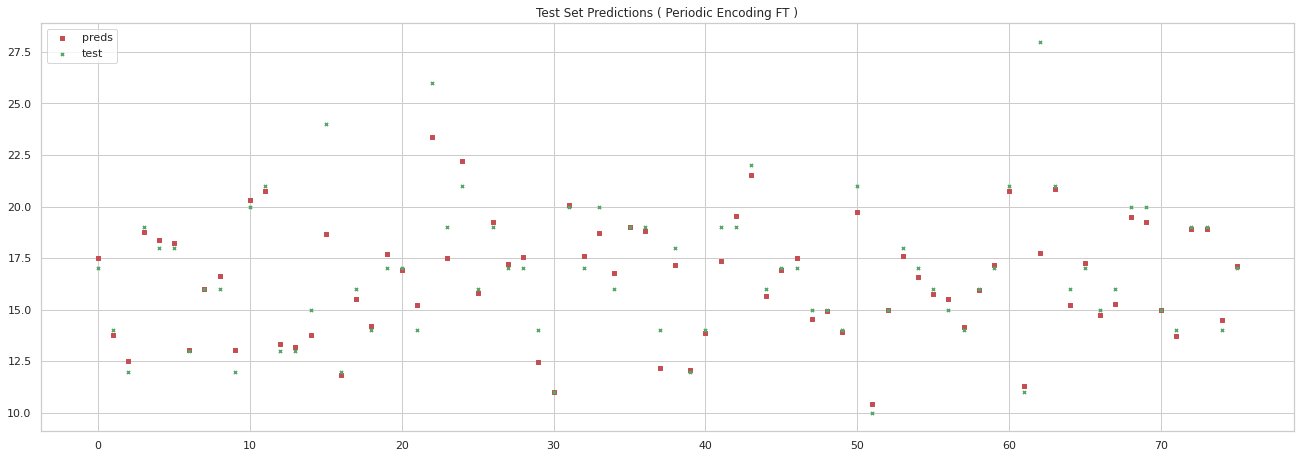

In [105]:
import matplotlib.pyplot as plt

results = pd.DataFrame(test_copy.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(111)

ax1.scatter(a["index"][:100], a["preds"].values[:100], s=10, c='r', marker="s", label='preds') # we can define number of rows we want to see in the plot as we wish to see.
ax1.scatter(a["index"][:100], a["real"].values[:100], s=10, c='g', marker="x", label='test')
plt.legend(loc='upper left')
plt.title("Test Set Predictions ( Periodic Encoding FT )")
plt.show()

### Linear Encoding Parameter Optimization

In [106]:
import optuna
import gc

def objective(trial):
    ft_encoder = FTTransformerEncoder(
        numerical_features = NUMERIC_FEATURES,
        categorical_features =CATEGORICAL_FEATURES,
        numerical_data = X_train[NUMERIC_FEATURES].values,
        categorical_data = X_train[CATEGORICAL_FEATURES].values,
        y = X_train[LABEL].values,
        numerical_embedding_type='linear',
        numerical_bins=trial.suggest_int('numerical_bins', 20, 200),
        embedding_dim=trial.suggest_int('embedding_dim', 8, 100),
        depth=trial.suggest_int('depth', 1, 6),
        heads=trial.suggest_int('heads', 2, 8),
        attn_dropout=trial.suggest_float('attn_dropout', 0., 0.5),
        ff_dropout=trial.suggest_float('ff_dropout', 0., 0.5),
        explainable=True
    )


    # Pass th encoder to the model
    ft_transformer = FTTransformer(
        encoder=ft_encoder,
        out_dim=1,
        out_activation="relu"
    )

    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.00001
    NUM_EPOCHS = 150

    optimizer = tfa.optimizers.AdamW(
            learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
        )

    ft_transformer.compile(
        optimizer = optimizer,
        loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
        metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
    )

    early = EarlyStopping(monitor="val_output_loss", mode="min", patience=20, restore_best_weights=True)
    callback_list = [early]

    ft_history = ft_transformer.fit(
        train_dataset, 
        epochs=NUM_EPOCHS, 
        validation_data=val_dataset,
        callbacks=callback_list
    ) 
    
    preds = ft_transformer.predict(test_dataset)
    
    rmse = mean_squared_error(test_data[LABEL], preds['output'].ravel(),squared=False)
    gc.collect()
    
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-01-16 01:48:26,824] A new study created in memory with name: no-name-dca90cac-9935-4051-8fe4-8632cba47d54


Epoch 1/150
2/2 [==============================] - 15s 2s/step - loss: 263.4814 - output_loss: 263.4814 - output_rmse: 16.2321 - val_loss: 185.9378 - val_output_loss: 185.9378 - val_output_rmse: 13.6359
Epoch 2/150
2/2 [==============================] - 0s 135ms/step - loss: 183.6286 - output_loss: 183.6286 - output_rmse: 13.5510 - val_loss: 160.5252 - val_output_loss: 160.5252 - val_output_rmse: 12.6699
Epoch 3/150
2/2 [==============================] - 0s 127ms/step - loss: 153.1527 - output_loss: 153.1527 - output_rmse: 12.3755 - val_loss: 133.6103 - val_output_loss: 133.6103 - val_output_rmse: 11.5590
Epoch 4/150
2/2 [==============================] - 0s 125ms/step - loss: 128.1268 - output_loss: 128.1268 - output_rmse: 11.3193 - val_loss: 114.9552 - val_output_loss: 114.9552 - val_output_rmse: 10.7217
Epoch 5/150
2/2 [==============================] - 0s 133ms/step - loss: 109.1166 - output_loss: 109.1166 - output_rmse: 10.4459 - val_loss: 104.6432 - val_output_loss: 104.6432 - va

[I 2023-01-16 01:49:06,231] Trial 0 finished with value: 3.3139089220063216 and parameters: {'numerical_bins': 199, 'embedding_dim': 34, 'depth': 5, 'heads': 7, 'attn_dropout': 0.05399816555074344, 'ff_dropout': 0.2658812267206985}. Best is trial 0 with value: 3.3139089220063216.


Epoch 1/150
2/2 [==============================] - 14s 2s/step - loss: 275.2665 - output_loss: 275.2665 - output_rmse: 16.5912 - val_loss: 175.2592 - val_output_loss: 175.2592 - val_output_rmse: 13.2385
Epoch 2/150
2/2 [==============================] - 0s 126ms/step - loss: 180.0332 - output_loss: 180.0332 - output_rmse: 13.4176 - val_loss: 125.4092 - val_output_loss: 125.4092 - val_output_rmse: 11.1986
Epoch 3/150
2/2 [==============================] - 0s 125ms/step - loss: 126.0852 - output_loss: 126.0852 - output_rmse: 11.2288 - val_loss: 99.1105 - val_output_loss: 99.1105 - val_output_rmse: 9.9554
Epoch 4/150
2/2 [==============================] - 0s 128ms/step - loss: 96.2893 - output_loss: 96.2893 - output_rmse: 9.8127 - val_loss: 87.0494 - val_output_loss: 87.0494 - val_output_rmse: 9.3300
Epoch 5/150
2/2 [==============================] - 0s 133ms/step - loss: 82.3507 - output_loss: 82.3507 - output_rmse: 9.0747 - val_loss: 78.8243 - val_output_loss: 78.8243 - val_output_rmse:

[I 2023-01-16 01:49:42,936] Trial 1 finished with value: 3.3139355801729753 and parameters: {'numerical_bins': 127, 'embedding_dim': 53, 'depth': 5, 'heads': 5, 'attn_dropout': 0.3408969732549321, 'ff_dropout': 0.2656623754993107}. Best is trial 0 with value: 3.3139089220063216.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 268.0391 - output_loss: 268.0391 - output_rmse: 16.3719 - val_loss: 113.0230 - val_output_loss: 113.0230 - val_output_rmse: 10.6312
Epoch 2/150
2/2 [==============================] - 0s 99ms/step - loss: 138.9422 - output_loss: 138.9422 - output_rmse: 11.7874 - val_loss: 63.9185 - val_output_loss: 63.9185 - val_output_rmse: 7.9949
Epoch 3/150
2/2 [==============================] - 0s 102ms/step - loss: 82.2773 - output_loss: 82.2773 - output_rmse: 9.0707 - val_loss: 40.9795 - val_output_loss: 40.9795 - val_output_rmse: 6.4015
Epoch 4/150
2/2 [==============================] - 0s 96ms/step - loss: 49.6786 - output_loss: 49.6786 - output_rmse: 7.0483 - val_loss: 30.7726 - val_output_loss: 30.7726 - val_output_rmse: 5.5473
Epoch 5/150
2/2 [==============================] - 0s 97ms/step - loss: 32.6037 - output_loss: 32.6037 - output_rmse: 5.7100 - val_loss: 24.5990 - val_output_loss: 24.5990 - val_output_rmse: 4.9597
E

[I 2023-01-16 01:50:02,176] Trial 2 finished with value: 3.3242129542911187 and parameters: {'numerical_bins': 140, 'embedding_dim': 92, 'depth': 2, 'heads': 3, 'attn_dropout': 0.177835115506203, 'ff_dropout': 0.37961019655348355}. Best is trial 0 with value: 3.3139089220063216.


Epoch 1/150
2/2 [==============================] - 12s 2s/step - loss: 247.5987 - output_loss: 247.5987 - output_rmse: 15.7353 - val_loss: 161.6770 - val_output_loss: 161.6770 - val_output_rmse: 12.7152
Epoch 2/150
2/2 [==============================] - 0s 118ms/step - loss: 166.7089 - output_loss: 166.7089 - output_rmse: 12.9116 - val_loss: 121.4033 - val_output_loss: 121.4033 - val_output_rmse: 11.0183
Epoch 3/150
2/2 [==============================] - 0s 113ms/step - loss: 125.1435 - output_loss: 125.1435 - output_rmse: 11.1868 - val_loss: 100.5450 - val_output_loss: 100.5450 - val_output_rmse: 10.0272
Epoch 4/150
2/2 [==============================] - 0s 112ms/step - loss: 101.6697 - output_loss: 101.6697 - output_rmse: 10.0831 - val_loss: 88.9717 - val_output_loss: 88.9717 - val_output_rmse: 9.4325
Epoch 5/150
2/2 [==============================] - 0s 113ms/step - loss: 86.6950 - output_loss: 86.6950 - output_rmse: 9.3110 - val_loss: 80.4426 - val_output_loss: 80.4426 - val_output

[I 2023-01-16 01:50:38,771] Trial 3 finished with value: 3.3139050159413794 and parameters: {'numerical_bins': 76, 'embedding_dim': 50, 'depth': 4, 'heads': 3, 'attn_dropout': 0.28728806762135234, 'ff_dropout': 0.3066410711848437}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 208.5996 - output_loss: 208.5996 - output_rmse: 14.4430 - val_loss: 73.1588 - val_output_loss: 73.1588 - val_output_rmse: 8.5533
Epoch 2/150
2/2 [==============================] - 0s 113ms/step - loss: 80.1104 - output_loss: 80.1104 - output_rmse: 8.9504 - val_loss: 35.1618 - val_output_loss: 35.1618 - val_output_rmse: 5.9297
Epoch 3/150
2/2 [==============================] - 0s 113ms/step - loss: 37.2327 - output_loss: 37.2327 - output_rmse: 6.1019 - val_loss: 21.3005 - val_output_loss: 21.3005 - val_output_rmse: 4.6153
Epoch 4/150
2/2 [==============================] - 0s 116ms/step - loss: 21.2215 - output_loss: 21.2215 - output_rmse: 4.6067 - val_loss: 16.6401 - val_output_loss: 16.6401 - val_output_rmse: 4.0792
Epoch 5/150
2/2 [==============================] - 0s 110ms/step - loss: 14.8113 - output_loss: 14.8113 - output_rmse: 3.8485 - val_loss: 13.9195 - val_output_loss: 13.9195 - val_output_rmse: 3.7309
Epoc

[I 2023-01-16 01:51:01,917] Trial 4 finished with value: 3.321329757763619 and parameters: {'numerical_bins': 111, 'embedding_dim': 70, 'depth': 3, 'heads': 6, 'attn_dropout': 0.13846046336844986, 'ff_dropout': 0.22018643460109438}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 14s 2s/step - loss: 278.7972 - output_loss: 278.7972 - output_rmse: 16.6972 - val_loss: 252.9456 - val_output_loss: 252.9456 - val_output_rmse: 15.9043
Epoch 2/150
2/2 [==============================] - 0s 131ms/step - loss: 236.3254 - output_loss: 236.3254 - output_rmse: 15.3729 - val_loss: 228.1392 - val_output_loss: 228.1392 - val_output_rmse: 15.1043
Epoch 3/150
2/2 [==============================] - 0s 127ms/step - loss: 213.9768 - output_loss: 213.9768 - output_rmse: 14.6279 - val_loss: 215.3882 - val_output_loss: 215.3882 - val_output_rmse: 14.6761
Epoch 4/150
2/2 [==============================] - 0s 129ms/step - loss: 200.8147 - output_loss: 200.8147 - output_rmse: 14.1709 - val_loss: 206.0349 - val_output_loss: 206.0349 - val_output_rmse: 14.3539
Epoch 5/150
2/2 [==============================] - 0s 121ms/step - loss: 191.6264 - output_loss: 191.6264 - output_rmse: 13.8429 - val_loss: 199.6032 - val_output_loss: 199.6032 - va

[I 2023-01-16 01:51:51,097] Trial 5 finished with value: 3.322111611126081 and parameters: {'numerical_bins': 126, 'embedding_dim': 26, 'depth': 5, 'heads': 5, 'attn_dropout': 0.15671085299663556, 'ff_dropout': 0.03959199415154341}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 13s 2s/step - loss: 271.3913 - output_loss: 271.3913 - output_rmse: 16.4740 - val_loss: 247.9973 - val_output_loss: 247.9973 - val_output_rmse: 15.7479
Epoch 2/150
2/2 [==============================] - 0s 118ms/step - loss: 235.2406 - output_loss: 235.2406 - output_rmse: 15.3376 - val_loss: 230.3686 - val_output_loss: 230.3686 - val_output_rmse: 15.1779
Epoch 3/150
2/2 [==============================] - 0s 111ms/step - loss: 218.1789 - output_loss: 218.1789 - output_rmse: 14.7709 - val_loss: 217.2473 - val_output_loss: 217.2473 - val_output_rmse: 14.7393
Epoch 4/150
2/2 [==============================] - 0s 114ms/step - loss: 207.1560 - output_loss: 207.1560 - output_rmse: 14.3929 - val_loss: 209.8976 - val_output_loss: 209.8976 - val_output_rmse: 14.4878
Epoch 5/150
2/2 [==============================] - 0s 125ms/step - loss: 199.1448 - output_loss: 199.1448 - output_rmse: 14.1119 - val_loss: 203.8529 - val_output_loss: 203.8529 - va

[I 2023-01-16 01:52:36,310] Trial 6 finished with value: 3.3238068837572796 and parameters: {'numerical_bins': 66, 'embedding_dim': 13, 'depth': 4, 'heads': 3, 'attn_dropout': 0.2167038919257161, 'ff_dropout': 0.18300554299831373}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 216.1070 - output_loss: 216.1070 - output_rmse: 14.7006 - val_loss: 50.9992 - val_output_loss: 50.9992 - val_output_rmse: 7.1414
Epoch 2/150
2/2 [==============================] - 0s 111ms/step - loss: 70.5598 - output_loss: 70.5598 - output_rmse: 8.4000 - val_loss: 21.5170 - val_output_loss: 21.5170 - val_output_rmse: 4.6386
Epoch 3/150
2/2 [==============================] - 0s 113ms/step - loss: 26.5143 - output_loss: 26.5143 - output_rmse: 5.1492 - val_loss: 13.7478 - val_output_loss: 13.7478 - val_output_rmse: 3.7078
Epoch 4/150
2/2 [==============================] - 0s 111ms/step - loss: 13.2939 - output_loss: 13.2939 - output_rmse: 3.6461 - val_loss: 11.1181 - val_output_loss: 11.1181 - val_output_rmse: 3.3344
Epoch 5/150
2/2 [==============================] - 0s 112ms/step - loss: 9.0379 - output_loss: 9.0379 - output_rmse: 3.0063 - val_loss: 10.0765 - val_output_loss: 10.0765 - val_output_rmse: 3.1744
Epoch 

[I 2023-01-16 01:52:57,012] Trial 7 finished with value: 3.3242476538996524 and parameters: {'numerical_bins': 52, 'embedding_dim': 91, 'depth': 3, 'heads': 6, 'attn_dropout': 0.3798092269434876, 'ff_dropout': 0.36932690799080864}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 12s 1s/step - loss: 263.8207 - output_loss: 263.8207 - output_rmse: 16.2426 - val_loss: 173.1645 - val_output_loss: 173.1645 - val_output_rmse: 13.1592
Epoch 2/150
2/2 [==============================] - 0s 114ms/step - loss: 159.7196 - output_loss: 159.7196 - output_rmse: 12.6380 - val_loss: 108.3980 - val_output_loss: 108.3980 - val_output_rmse: 10.4114
Epoch 3/150
2/2 [==============================] - 0s 112ms/step - loss: 98.6125 - output_loss: 98.6125 - output_rmse: 9.9304 - val_loss: 88.0517 - val_output_loss: 88.0517 - val_output_rmse: 9.3836
Epoch 4/150
2/2 [==============================] - 0s 127ms/step - loss: 78.7335 - output_loss: 78.7335 - output_rmse: 8.8732 - val_loss: 74.6319 - val_output_loss: 74.6319 - val_output_rmse: 8.6390
Epoch 5/150
2/2 [==============================] - 0s 111ms/step - loss: 65.4487 - output_loss: 65.4487 - output_rmse: 8.0900 - val_loss: 61.8521 - val_output_loss: 61.8521 - val_output_rmse: 7.

[I 2023-01-16 01:53:21,778] Trial 8 finished with value: 3.320328763069196 and parameters: {'numerical_bins': 155, 'embedding_dim': 73, 'depth': 3, 'heads': 6, 'attn_dropout': 0.415593033855676, 'ff_dropout': 0.034074171976776924}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 16s 2s/step - loss: 267.9861 - output_loss: 267.9861 - output_rmse: 16.3703 - val_loss: 93.4102 - val_output_loss: 93.4102 - val_output_rmse: 9.6649
Epoch 2/150
2/2 [==============================] - 0s 148ms/step - loss: 128.5103 - output_loss: 128.5103 - output_rmse: 11.3362 - val_loss: 59.6558 - val_output_loss: 59.6558 - val_output_rmse: 7.7237
Epoch 3/150
2/2 [==============================] - 0s 144ms/step - loss: 68.3735 - output_loss: 68.3735 - output_rmse: 8.2688 - val_loss: 41.0411 - val_output_loss: 41.0411 - val_output_rmse: 6.4063
Epoch 4/150
2/2 [==============================] - 0s 145ms/step - loss: 42.5391 - output_loss: 42.5391 - output_rmse: 6.5222 - val_loss: 31.8051 - val_output_loss: 31.8051 - val_output_rmse: 5.6396
Epoch 5/150
2/2 [==============================] - 0s 142ms/step - loss: 29.8924 - output_loss: 29.8924 - output_rmse: 5.4674 - val_loss: 26.9553 - val_output_loss: 26.9553 - val_output_rmse: 5.1919
E

[I 2023-01-16 01:53:51,781] Trial 9 finished with value: 3.3212633369183098 and parameters: {'numerical_bins': 22, 'embedding_dim': 86, 'depth': 6, 'heads': 4, 'attn_dropout': 0.020382090928370955, 'ff_dropout': 0.490908311803086}. Best is trial 3 with value: 3.3139050159413794.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 239.7693 - output_loss: 239.7693 - output_rmse: 15.4845 - val_loss: 165.9483 - val_output_loss: 165.9483 - val_output_rmse: 12.8821
Epoch 2/150
2/2 [==============================] - 0s 89ms/step - loss: 165.5973 - output_loss: 165.5973 - output_rmse: 12.8685 - val_loss: 158.6207 - val_output_loss: 158.6207 - val_output_rmse: 12.5945
Epoch 3/150
2/2 [==============================] - 0s 88ms/step - loss: 155.1707 - output_loss: 155.1707 - output_rmse: 12.4568 - val_loss: 145.2948 - val_output_loss: 145.2948 - val_output_rmse: 12.0538
Epoch 4/150
2/2 [==============================] - 0s 85ms/step - loss: 142.8656 - output_loss: 142.8656 - output_rmse: 11.9526 - val_loss: 132.5706 - val_output_loss: 132.5706 - val_output_rmse: 11.5139
Epoch 5/150
2/2 [==============================] - 0s 87ms/step - loss: 130.3771 - output_loss: 130.3771 - output_rmse: 11.4183 - val_loss: 121.5201 - val_output_loss: 121.5201 - val_out

[I 2023-01-16 01:54:16,193] Trial 10 finished with value: 3.313350739715945 and parameters: {'numerical_bins': 81, 'embedding_dim': 49, 'depth': 1, 'heads': 2, 'attn_dropout': 0.49830290442999714, 'ff_dropout': 0.13812603090344916}. Best is trial 10 with value: 3.313350739715945.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 272.9259 - output_loss: 272.9259 - output_rmse: 16.5205 - val_loss: 235.7186 - val_output_loss: 235.7186 - val_output_rmse: 15.3531
Epoch 2/150
2/2 [==============================] - 0s 88ms/step - loss: 220.3026 - output_loss: 220.3026 - output_rmse: 14.8426 - val_loss: 189.9876 - val_output_loss: 189.9876 - val_output_rmse: 13.7836
Epoch 3/150
2/2 [==============================] - 0s 84ms/step - loss: 180.4918 - output_loss: 180.4918 - output_rmse: 13.4347 - val_loss: 158.1408 - val_output_loss: 158.1408 - val_output_rmse: 12.5754
Epoch 4/150
2/2 [==============================] - 0s 86ms/step - loss: 153.6311 - output_loss: 153.6311 - output_rmse: 12.3948 - val_loss: 143.6053 - val_output_loss: 143.6053 - val_output_rmse: 11.9835
Epoch 5/150
2/2 [==============================] - 0s 87ms/step - loss: 139.7471 - output_loss: 139.7471 - output_rmse: 11.8215 - val_loss: 133.0844 - val_output_loss: 133.0844 - val_out

[I 2023-01-16 01:54:51,561] Trial 11 finished with value: 3.0781785255547227 and parameters: {'numerical_bins': 76, 'embedding_dim': 47, 'depth': 1, 'heads': 2, 'attn_dropout': 0.4987129595492019, 'ff_dropout': 0.1463148218647324}. Best is trial 11 with value: 3.0781785255547227.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 266.0575 - output_loss: 266.0575 - output_rmse: 16.3113 - val_loss: 263.7729 - val_output_loss: 263.7729 - val_output_rmse: 16.2411
Epoch 2/150
2/2 [==============================] - 0s 87ms/step - loss: 247.7919 - output_loss: 247.7919 - output_rmse: 15.7414 - val_loss: 250.4137 - val_output_loss: 250.4137 - val_output_rmse: 15.8245
Epoch 3/150
2/2 [==============================] - 0s 86ms/step - loss: 234.3385 - output_loss: 234.3385 - output_rmse: 15.3081 - val_loss: 233.3631 - val_output_loss: 233.3631 - val_output_rmse: 15.2762
Epoch 4/150
2/2 [==============================] - 0s 88ms/step - loss: 221.2300 - output_loss: 221.2300 - output_rmse: 14.8738 - val_loss: 218.9298 - val_output_loss: 218.9298 - val_output_rmse: 14.7963
Epoch 5/150
2/2 [==============================] - 0s 85ms/step - loss: 207.2557 - output_loss: 207.2557 - output_rmse: 14.3964 - val_loss: 207.3297 - val_output_loss: 207.3297 - val_out

[I 2023-01-16 01:55:26,108] Trial 12 finished with value: 3.3134495811290354 and parameters: {'numerical_bins': 88, 'embedding_dim': 41, 'depth': 1, 'heads': 2, 'attn_dropout': 0.48399033470442954, 'ff_dropout': 0.11857837499288844}. Best is trial 11 with value: 3.0781785255547227.


Epoch 1/150
2/2 [==============================] - 9s 1s/step - loss: 278.2604 - output_loss: 278.2604 - output_rmse: 16.6811 - val_loss: 189.6810 - val_output_loss: 189.6810 - val_output_rmse: 13.7725
Epoch 2/150
2/2 [==============================] - 0s 86ms/step - loss: 184.4279 - output_loss: 184.4279 - output_rmse: 13.5804 - val_loss: 147.9217 - val_output_loss: 147.9217 - val_output_rmse: 12.1623
Epoch 3/150
2/2 [==============================] - 0s 88ms/step - loss: 141.9134 - output_loss: 141.9134 - output_rmse: 11.9127 - val_loss: 114.8987 - val_output_loss: 114.8987 - val_output_rmse: 10.7191
Epoch 4/150
2/2 [==============================] - 0s 86ms/step - loss: 112.3662 - output_loss: 112.3662 - output_rmse: 10.6003 - val_loss: 98.3369 - val_output_loss: 98.3369 - val_output_rmse: 9.9165
Epoch 5/150
2/2 [==============================] - 0s 86ms/step - loss: 96.6764 - output_loss: 96.6764 - output_rmse: 9.8324 - val_loss: 86.7015 - val_output_loss: 86.7015 - val_output_rmse

[I 2023-01-16 01:56:01,197] Trial 13 finished with value: 2.771360300253011 and parameters: {'numerical_bins': 40, 'embedding_dim': 64, 'depth': 1, 'heads': 2, 'attn_dropout': 0.49817195877467446, 'ff_dropout': 0.13324045968272216}. Best is trial 13 with value: 2.771360300253011.


Epoch 1/150
2/2 [==============================] - 10s 1s/step - loss: 274.8238 - output_loss: 274.8238 - output_rmse: 16.5778 - val_loss: 220.5522 - val_output_loss: 220.5522 - val_output_rmse: 14.8510
Epoch 2/150
2/2 [==============================] - 0s 95ms/step - loss: 207.0999 - output_loss: 207.0999 - output_rmse: 14.3910 - val_loss: 181.9298 - val_output_loss: 181.9298 - val_output_rmse: 13.4881
Epoch 3/150
2/2 [==============================] - 0s 97ms/step - loss: 171.9987 - output_loss: 171.9987 - output_rmse: 13.1148 - val_loss: 155.4389 - val_output_loss: 155.4389 - val_output_rmse: 12.4675
Epoch 4/150
2/2 [==============================] - 0s 96ms/step - loss: 147.3184 - output_loss: 147.3184 - output_rmse: 12.1375 - val_loss: 137.7270 - val_output_loss: 137.7270 - val_output_rmse: 11.7357
Epoch 5/150
2/2 [==============================] - 0s 95ms/step - loss: 130.8898 - output_loss: 130.8898 - output_rmse: 11.4407 - val_loss: 127.3912 - val_output_loss: 127.3912 - val_ou

[I 2023-01-16 01:56:26,809] Trial 14 finished with value: 3.3140610539280897 and parameters: {'numerical_bins': 31, 'embedding_dim': 67, 'depth': 2, 'heads': 2, 'attn_dropout': 0.4340917811840319, 'ff_dropout': 0.09051626263180132}. Best is trial 13 with value: 2.771360300253011.


Number of finished trials: 15
Best trial: {'numerical_bins': 40, 'embedding_dim': 64, 'depth': 1, 'heads': 2, 'attn_dropout': 0.49817195877467446, 'ff_dropout': 0.13324045968272216}


In [107]:
study.best_trial.params

{'numerical_bins': 40,
 'embedding_dim': 64,
 'depth': 1,
 'heads': 2,
 'attn_dropout': 0.49817195877467446,
 'ff_dropout': 0.13324045968272216}

In [108]:
ft_linear_encoder = FTTransformerEncoder(
    numerical_features = NUMERIC_FEATURES,
    categorical_features = CATEGORICAL_FEATURES,
    numerical_data = X_train[NUMERIC_FEATURES].values,
    categorical_data = X_train[CATEGORICAL_FEATURES].values,
    y = X_train[LABEL].values,
    numerical_embedding_type='linear',
    numerical_bins=137,
    embedding_dim=90,
    depth=4,
    heads=3,
    attn_dropout= 0.3387067037591105,
    ff_dropout= 0.137421939824639,
    explainable=True
)

# Pass th encoder to the model
ft_linear_encoder_transformer = FTTransformer(
    encoder=ft_linear_encoder,
    out_dim=1,
    out_activation="relu",
)

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
NUM_EPOCHS = 250

optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

ft_linear_encoder_transformer.compile(
    optimizer = optimizer,
    loss = {"output": tf.keras.losses.MeanSquaredError(name='mse'), "importances": None},
    metrics= {"output": [tf.keras.metrics.RootMeanSquaredError(name='rmse')], "importances": None},
)

early = EarlyStopping(monitor="val_output_loss", mode="min", patience=16, restore_best_weights=True)
callback_list = [early]

ft_linear_history = ft_linear_encoder_transformer.fit(
    train_dataset, 
    epochs=NUM_EPOCHS, 
    validation_data=val_dataset,
    callbacks=callback_list
)

Epoch 1/250
2/2 [==============================] - 13s 2s/step - loss: 264.3755 - output_loss: 264.3755 - output_rmse: 16.2596 - val_loss: 90.8161 - val_output_loss: 90.8161 - val_output_rmse: 9.5297
Epoch 2/250
2/2 [==============================] - 0s 117ms/step - loss: 88.8720 - output_loss: 88.8720 - output_rmse: 9.4272 - val_loss: 38.4566 - val_output_loss: 38.4566 - val_output_rmse: 6.2013
Epoch 3/250
2/2 [==============================] - 0s 116ms/step - loss: 37.0613 - output_loss: 37.0613 - output_rmse: 6.0878 - val_loss: 24.9201 - val_output_loss: 24.9201 - val_output_rmse: 4.9920
Epoch 4/250
2/2 [==============================] - 0s 115ms/step - loss: 22.5825 - output_loss: 22.5825 - output_rmse: 4.7521 - val_loss: 18.3031 - val_output_loss: 18.3031 - val_output_rmse: 4.2782
Epoch 5/250
2/2 [==============================] - 0s 118ms/step - loss: 14.8743 - output_loss: 14.8743 - output_rmse: 3.8567 - val_loss: 12.5249 - val_output_loss: 12.5249 - val_output_rmse: 3.5391
Epoc

In [109]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)

1/1 [==============================] - 1s 1s/step


In [110]:
linear_tuned_test_preds = ft_linear_encoder_transformer.predict(test_dataset)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_rms = mean_squared_error(test_data[LABEL], linear_tuned_test_preds['output'].ravel(), squared=False)
linear_tuned_mae = mae(test_data[LABEL], linear_tuned_test_preds['output'].ravel())
linear_tuned_r2 = r2_score(test_data[LABEL], linear_tuned_test_preds['output'].ravel())


1/1 [==============================] - 0s 31ms/step


### Tuned Linear Encoding - Transformer Model Graphs

Text(0, 0.5, '% difference between real values and predictions ( Linear Encoding FT )')

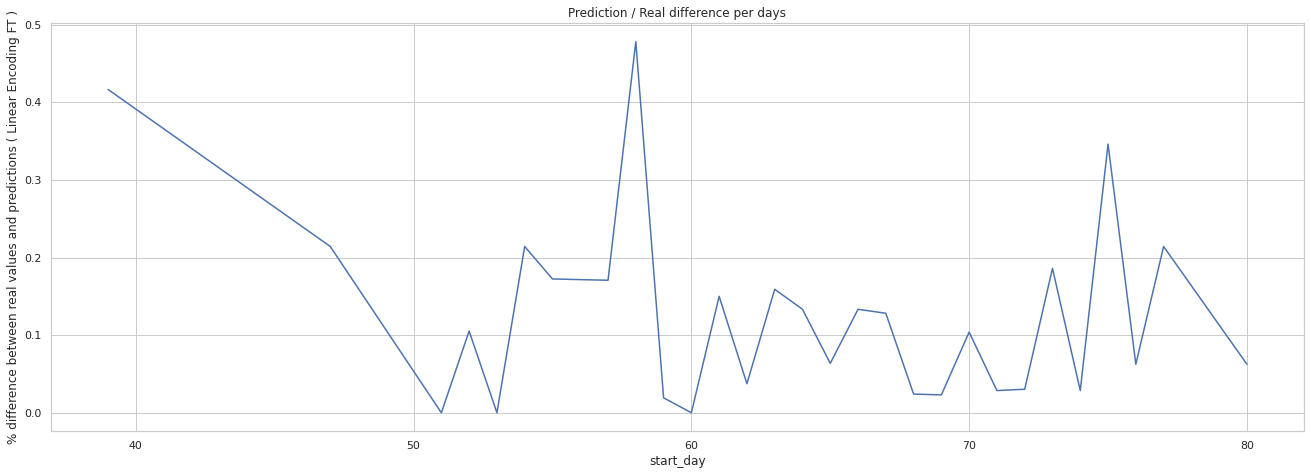

In [111]:
test_copy = df.loc[(df.dataset == "test") & (df.duration.notnull())].copy()
test_copy["preds"] = linear_tuned_test_preds['output'].ravel()
test_copy["daily_preds_sum"] = test_copy.groupby("start_day")["preds"].transform("sum").astype(int)
test_copy["daily_real_sum"] = test_copy.groupby("start_day")["duration"].transform("sum")
temp = test_copy.drop_duplicates(subset = ["start_day", "daily_preds_sum", "daily_real_sum"])[["start_day", "daily_preds_sum", "daily_real_sum"]].sort_values("start_day")
temp["daily_difference"] = abs(temp["daily_real_sum"] - temp["daily_preds_sum"])/temp.daily_real_sum
plt.figure(figsize = (20,7))
sns.lineplot(x = temp.start_day, y = temp.daily_difference)
plt.title("Prediction / Real difference per days")
plt.ylabel("% difference between real values and predictions ( Linear Encoding FT )")

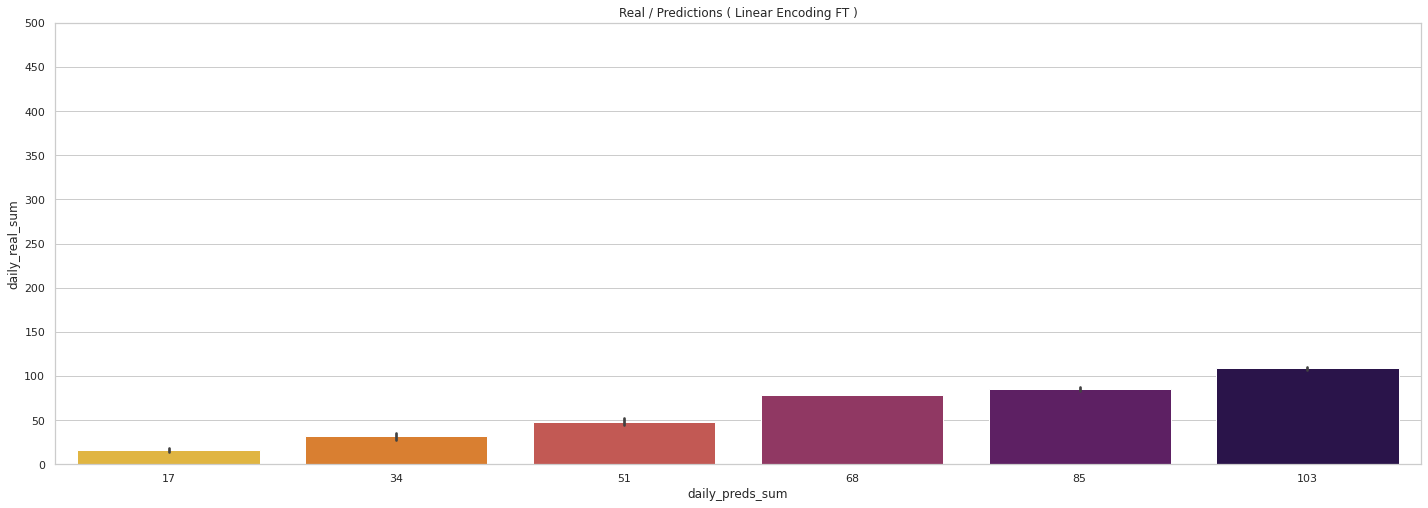

In [112]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.daily_preds_sum[:20], y = temp.daily_real_sum[:20], palette = "inferno_r")
plt.tight_layout()
plt.yticks(np.arange(0,550,50))
plt.title("Real / Predictions ( Linear Encoding FT )")
plt.show()

Text(0.5, 1.0, 'Daily differences between real values and predictions ( Linear Encoding FT )')

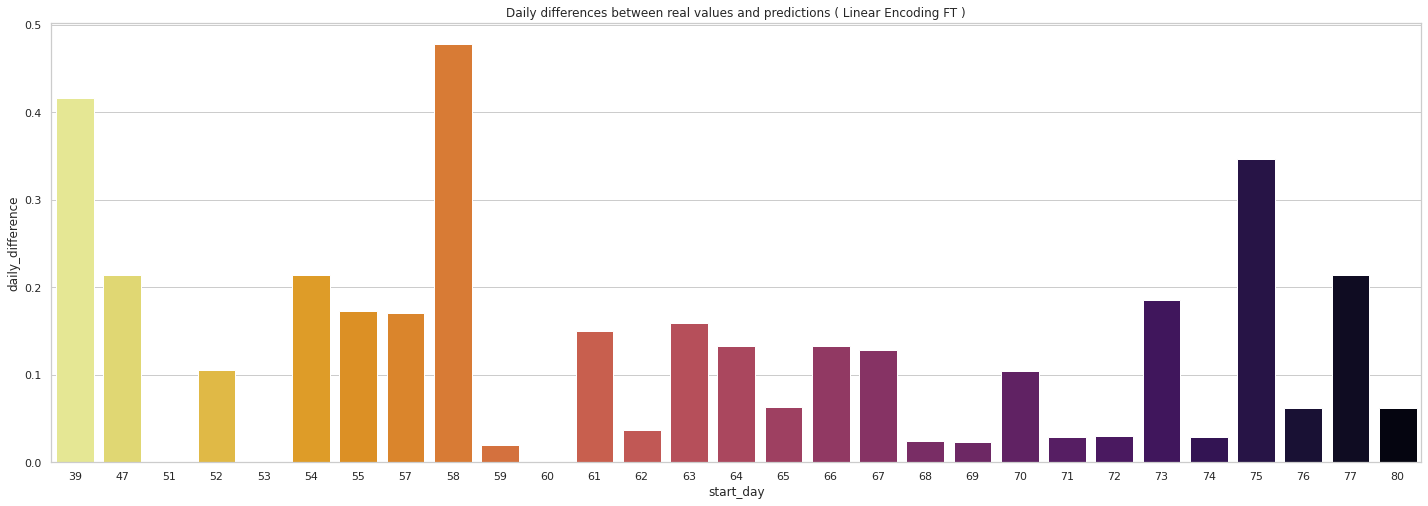

In [113]:
plt.figure(figsize = (20,7))
sns.barplot(x = temp.start_day, y =temp.daily_difference, palette = "inferno_r")
plt.tight_layout()
plt.title("Daily differences between real values and predictions ( Linear Encoding FT )")

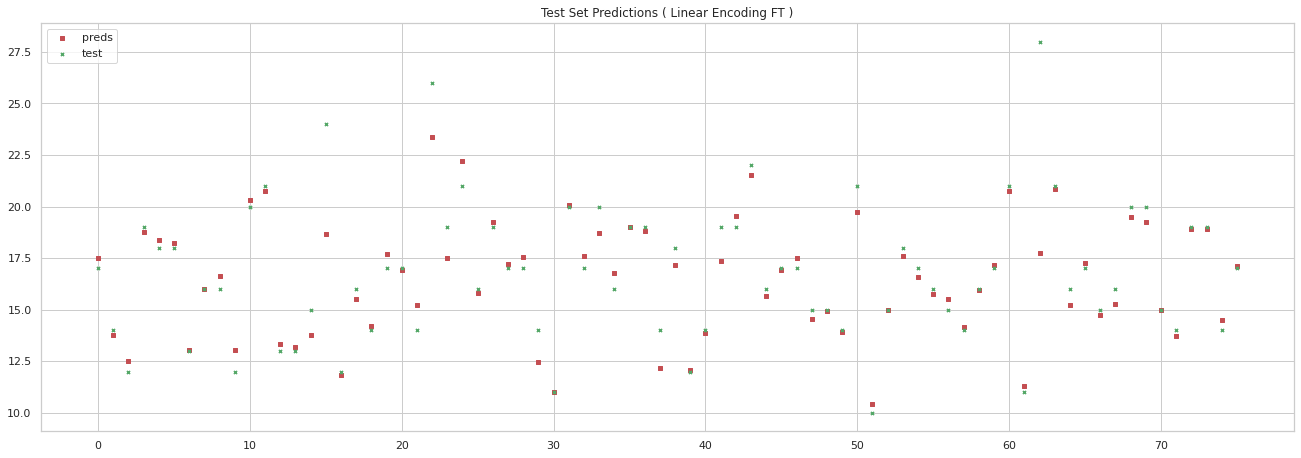

In [114]:
import matplotlib.pyplot as plt

results = pd.DataFrame(test_copy.duration.values, columns = ["real"])
results["preds"] = real_preds
a = results.reset_index()
fig = plt.figure(figsize = (20,7))
ax1 = fig.add_subplot(111)

ax1.scatter(a["index"][:100], a["preds"].values[:100], s=10, c='r', marker="s", label='preds') # we can define number of rows we want to see in the plot as we wish to see.
ax1.scatter(a["index"][:100], a["real"].values[:100], s=10, c='g', marker="x", label='test')
plt.legend(loc='upper left')
plt.title("Test Set Predictions ( Linear Encoding FT )")
plt.show()

### Our results were like this :

In [115]:
before_optimization = pd.DataFrame({"r2" : [linear_r2, periodic_r2, lgb_r2],
              "mae" : [linear_mae, period_mae, lgb_mae],
              "rmse" : [linear_rms, periodic_rms, lgb_rmse]}, index = ["Transformer - Linear Encoding", "Transformer - Periodic Encoding",
                     "LightGBM"]) # parameter needs more iterations
before_optimization

,r2,mae,rmse
Transformer - Linear Encoding,-0.008287,2.566074,3.327612
Transformer - Periodic Encoding,-0.008287,2.565643,3.325787
LightGBM,0.775770,0.686451,1.569234


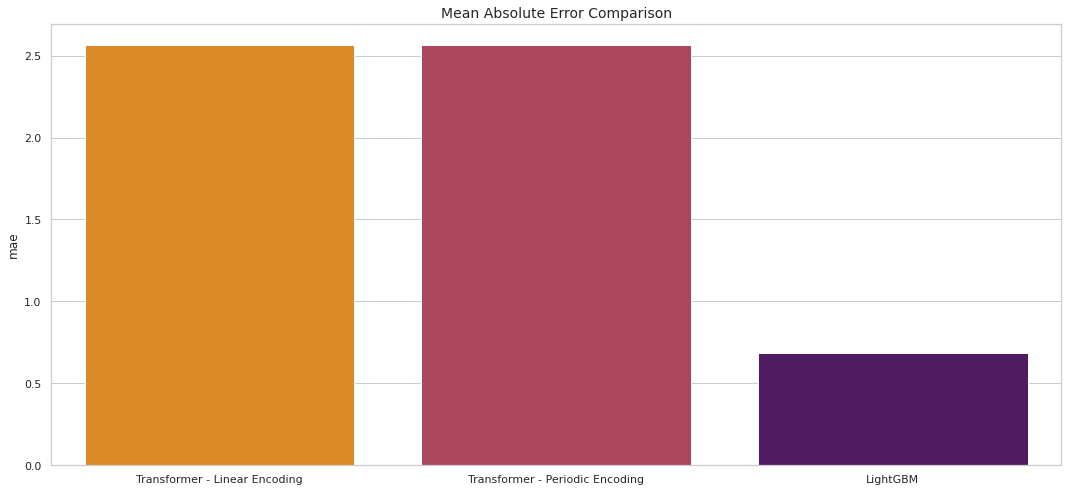

In [116]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


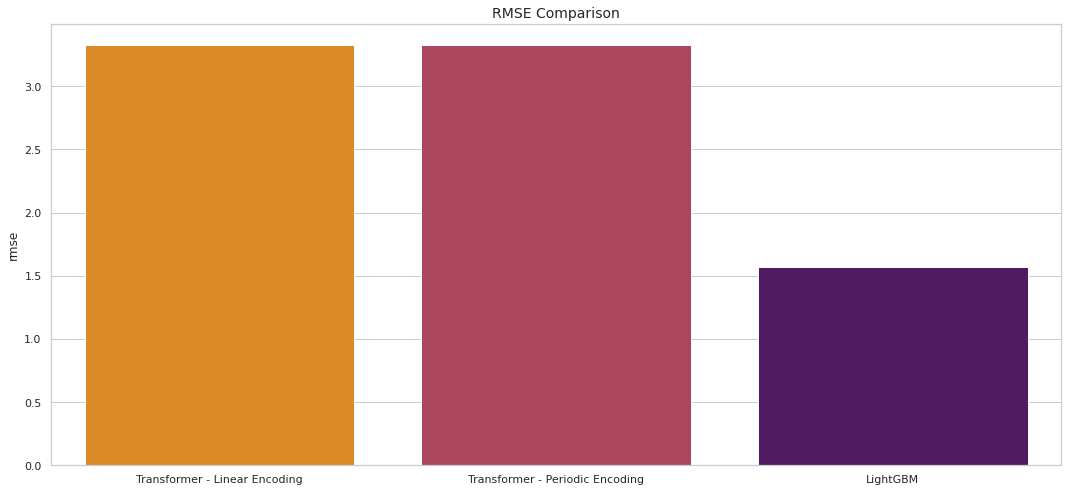

In [117]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


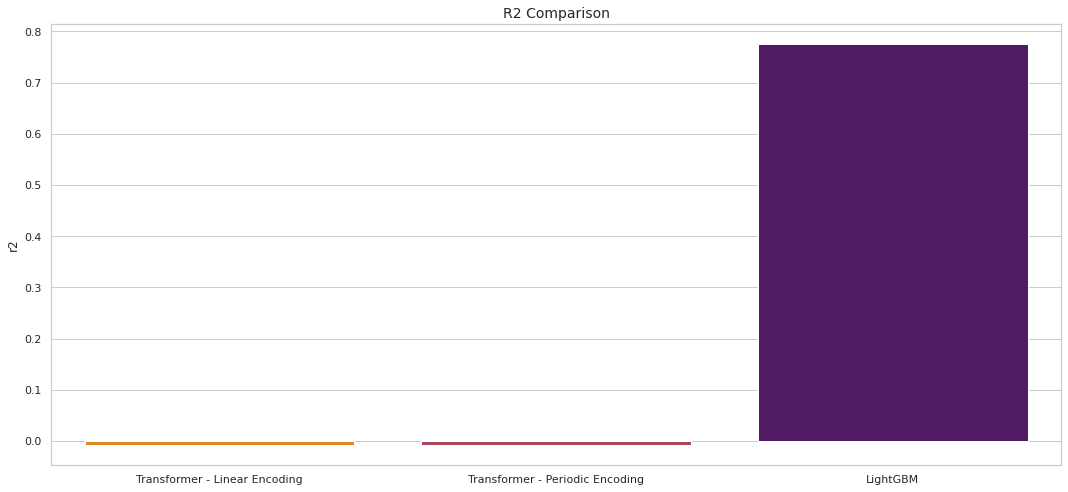

In [118]:
plt.figure(figsize = (15,7))
sns.barplot(x = before_optimization.index, y = before_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()


### After optimization:

In [119]:
after_optimization = pd.DataFrame({"r2" : [linear_tuned_r2, periodic_tuned_r2, lgb_tuned_r2],
              "mae" : [linear_tuned_mae, periodic_tuned_mae, lgb_tuned_mae],
              "rmse" : [linear_tuned_rms, periodic_tuned_rms, lgb_tuned_rmse]}, index = ["Transformer - Linear Encoding TUNED", "Transformer - Periodic Encoding TUNED",
                     "LightGBM TUNED"]) # parameter needs more iterations
after_optimization

,r2,mae,rmse
Transformer - Linear Encoding TUNED,-0.012617,2.597092,3.334750
Transformer - Periodic Encoding TUNED,-0.002141,2.562184,3.317454
LightGBM TUNED,0.797873,0.671959,1.489884


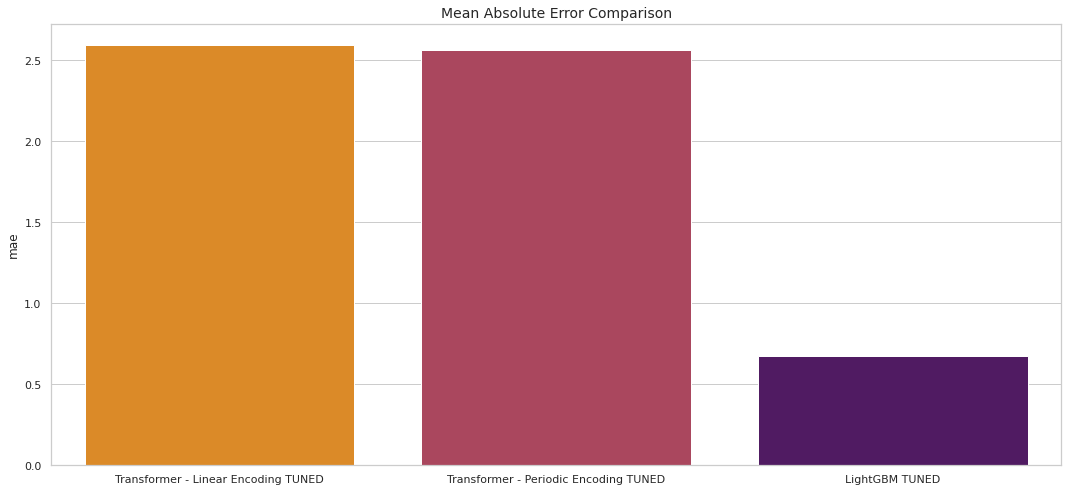

In [120]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.mae,palette = "inferno_r")
plt.title("Mean Absolute Error Comparison", fontsize = 14)
plt.tight_layout()


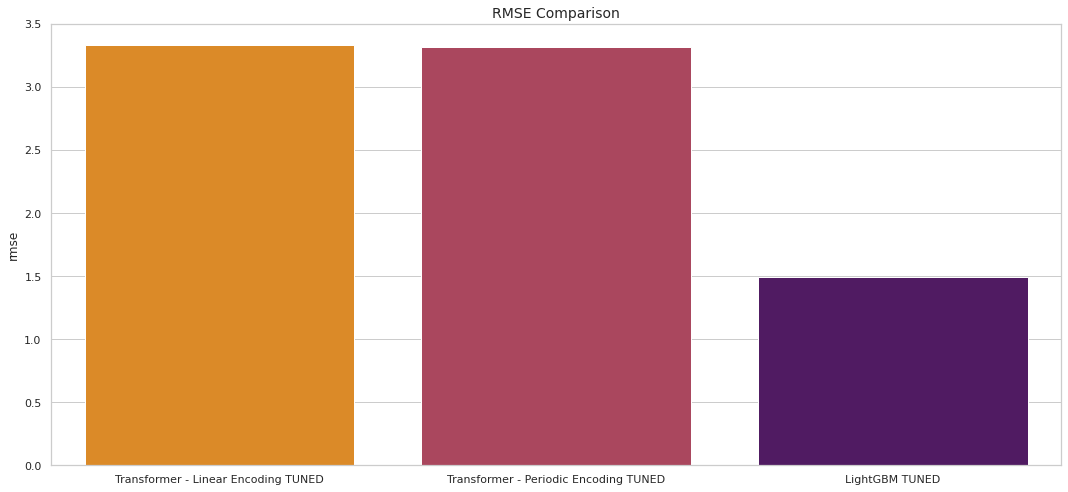

In [121]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.rmse,palette = "inferno_r")
plt.title("RMSE Comparison", fontsize = 14)
plt.tight_layout()


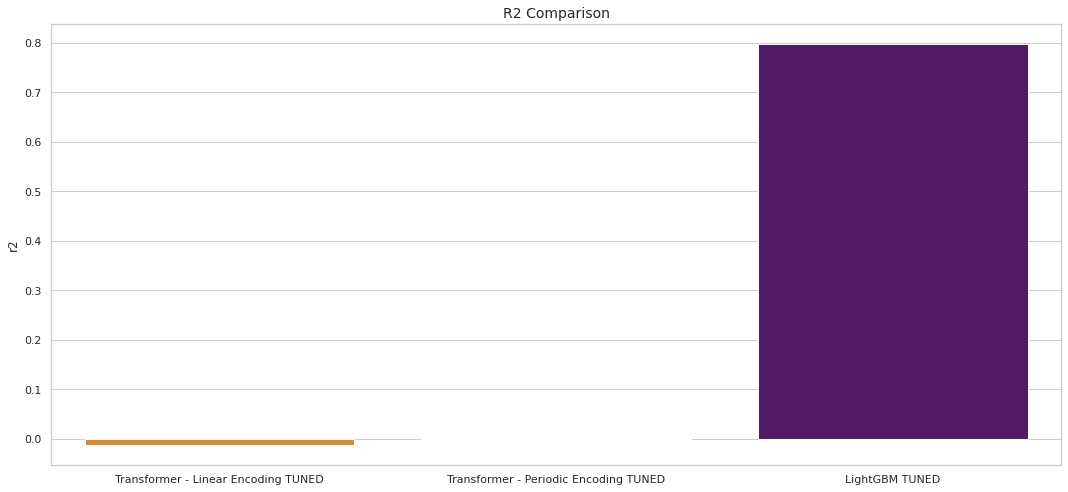

In [122]:
plt.figure(figsize = (15,7))
sns.barplot(x = after_optimization.index, y = after_optimization.r2,palette = "inferno_r")
plt.title("R2 Comparison", fontsize = 14)
plt.tight_layout()
